In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import utils
from sklearn.metrics import f1_score, accuracy_score

# set seed
random.seed(0)
np.random.seed(0)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

PREPROCESSED = Path('../data/preprocessed')
ASSETS = Path ('../assets/majestic-1000')
CHART_FILE_EXTENSION = ".svg"

df = pd.read_csv(PREPROCESSED / 'resources.csv')

cols = ['packets', 'sizes', 'ip_src', 'ip_dst', 'rel_time', 'incoming', 'incoming_sizes', 'outgoing', 'outgoing_sizes']
for col in cols:
    df[col] = df[col].apply(eval)

df.head()

,id,url,connection_id,ip,protocol,method,website_call,start,end_header,end_stream,content,first_party,context,ip_context,packets,hostname,is_tp,study_name,is_tracker,filter,sizes,ip_src,ip_dst,rel_time,start_time,end_time,delta_req_time,incoming,incoming_sizes,outgoing,outgoing_sizes
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,http2,GET,mozilla.org,20,26.0,26.0,text/html,www.mozilla.org,mozilla.org,13.32.119.185,"[20, 26]",mozilla.org,False,before accept,False,NaN,"[347, 435]","[172.17.0.4, 44.236.72.93]","[44.236.72.93, 172.17.0.4]","[0.404504, 0.595066]",0.404504,0.595066,0.000000,[26],[435],[20],[347]
1,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,"[51, 59, 61]",mozilla.org,False,before accept,False,NaN,"[351, 1460, 305]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.6612, 0.6762, 0.676207]",0.661200,0.676207,0.000000,"[59, 61]","[1460, 305]",[51],[351]
2,815a3078fff2a4cd95623602374ca6ff1b6cf1628e368dd60e1dc44b,https://www.mozilla.org/en-US/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,65,81.0,84.0,text/html; charset=utf-8,www.mozilla.org,mozilla.org,13.32.119.185,"[65, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84]",mozilla.org,False,before accept,False,NaN,"[56, 1460, 1460, 1460, 1332, 1428, 1460, 1460, 1460, 1460, 1300, 1460, 1460, 1460, 1332, 1352]","[172.17.0.4, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.677486, 0.693474, 0.693644, 0.693651, 0.693653, 0.693655, 0.693963, 0.693986, 0.693987, 0.693988, 0.693989, 0.694866, 0.694871, 0.694873, 0.694874, 0.694875]",0.677486,0.694875,0.016286,"[67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84]","[1460, 1460, 1460, 1332, 1428, 1460, 1460, 1460, 1460, 1300, 1460, 1460, 1460, 1332, 1352]",[65],[56]
3,5d10a4d49a66e53dc9ab3aa886139668faa92c3ee3bbcba0c059a982,https://www.mozilla.org/media/js/site.7afc1ba3aa92.js,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,86,108.0,108.0,application/javascript,www.mozilla.org,mozilla.org,13.32.119.185,"[86, 107, 108]",mozilla.org,False,before accept,False,NaN,"[163, 1460, 1240]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.707143, 0.722181, 0.72219]",0.707143,0.722190,0.029657,"[107, 108]","[1460, 1240]",[86],[163]
4,1a3a38bda292310aeefc8acaed61808455b194791404e39153ad6daf,https://www.mozilla.org/media/css/protocol-mozilla.120b0a0d8b56.css,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,http2,GET,mozilla.org,88,117.0,117.0,text/css,www.mozilla.org,mozilla.org,13.32.119.185,"[88, 110, 111, 112, 113, 114, 115, 116, 117]",mozilla.org,False,before accept,False,NaN,"[104, 1460, 1460, 1460, 1460, 1300, 1460, 1396, 250]","[172.17.0.4, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.708264, 0.72345, 0.723454, 0.723456, 0.723457, 0.723458, 0.723866, 0.723887, 0.723898]",0.708264,0.723898,0.001121,"[110, 111, 112, 113, 114, 115, 116, 117]","[1460, 1460, 1460, 1460, 1300, 1460, 1396, 250]",[88],[104]


## Feature Engineering

In [2]:
def split_by_webpage(df, test_size=0.2):
    websites = df['website_call'].unique().tolist()
    test_websites = random.sample(websites, math.ceil(test_size*len(websites)))
    train = utils.shuffle(df[~df['website_call'].isin(test_websites)])
    test = utils.shuffle(df[df['website_call'].isin(test_websites)])
    return train, test

df_train, df_test = split_by_webpage(df, test_size=0.3)

In [4]:
import warnings
    
def train_prevalence_ip(df):
    len_unique_webcalls = len(df['website_call'].unique())
    prevalence = df.groupby('ip').apply(lambda gp: len(gp['website_call'].unique()) / len_unique_webcalls)
    prevalence.name = 'ip_prevalence'
    return prevalence

def min_coll(collection):
    return np.min(collection) if len(collection) > 0 else None

def max_coll(collection):
    return np.max(collection) if len(collection) > 0 else None

def descriptive_statistics(df, col, level='R', precision=3):
    X = pd.DataFrame()
    col_name = lambda col, f: f"{level}:{f}({col})"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        X[col_name(col, "sum")] = df[col].apply(lambda x: np.sum(x)).round(precision)
        X[col_name(col, "mean")] = df[col].apply(lambda x: np.mean(x)).round(precision)
        X[col_name(col, "std")] = df[col].apply(lambda x: np.std(x)).round(precision)
        X[col_name(col, "min")] = df[col].apply(min_coll).round(precision)
        X[col_name(col, "max")] = df[col].apply(max_coll).round(precision)
        X[col_name(col, "span")] = X[col_name(col, "max")] - X[col_name(col, "min")]
    
    return X
  
def extract_communication_features(df, prevalence_ip=None):
    gp = df.groupby(['study_name', 'website_call', 'ip'])
    rs_tolist = lambda rs: [x for r in rs.tolist() for x in r]
    fns = {col: rs_tolist for col in ['packets', 'incoming', 'outgoing', 'sizes', 'incoming_sizes', 'outgoing_sizes', 'rel_time']}
    communication = gp.agg(fns | {'delta_req_time': lambda rs: rs.tolist()})
    
    communication['resource_sizes'] = gp.agg({'sizes': lambda rs: [sum(r) for r in rs.tolist()]})
    
        
    communication_r = communication.rename(columns={'outgoing': 'out packets', 'outgoing_sizes': 'out sizes', 
                                                    'incoming': 'in packets', 'incoming_sizes': 'in sizes',
                                                    'rel_time': 'rel time', 'delta_req_time': 'delta req time',
                                                    'resource_sizes': 'resource sizes'})
    
    X = pd.DataFrame()
    X['C:count(resources)'] = communication['resource_sizes'].apply(len)
    cols = ['packets', 'in packets', 'out packets']
    for col in cols:
        X[f"C:count({col})"] = communication_r[col].apply(len)
           
    cols = ['resource sizes', 'sizes', 'in sizes', 'out sizes', 'rel time', 'delta req time']
    for col in cols:
        X = pd.concat([X, descriptive_statistics(communication_r, col, level='C')], axis=1)
        
    if prevalence_ip is not None:
        communication = communication.join(prevalence_ip, on='ip')
        X['C:iprevalence(ip)'] = communication['ip_prevalence']
        
    X.drop(columns=['C:sum(resource sizes)', 'C:min(delta req time)', 'C:span(delta req time)', 'C:sum(rel time)'], inplace=True)
    cols = X.columns
    X = df.merge(X, left_on=['study_name', 'website_call', 'ip'], right_index=True)
    X = X.loc[df.index]
    
    return X[cols].fillna(-1)

def extract_resource_features(df):
    df_r = df.rename(columns={'outgoing': 'out packets', 'outgoing_sizes': 'out sizes', 
                                                    'incoming': 'in packets', 'incoming_sizes': 'in sizes',
                                                    'rel_time': 'rel time', 'delta_time': 'delta req time'})
    
    X = pd.DataFrame()
    cols = ['packets', 'in packets', 'out packets']
    for col in cols:
        X[f"R:count({col})"] = df_r[col].apply(len)
    
    cols = ['sizes', 'in sizes', 'out sizes', 'rel time']
    for col in cols:
        X = pd.concat([X, descriptive_statistics(df_r, col, level='R')], axis=1)
        
    X['R:delta req time'] = df['delta_req_time']
    X.drop(columns=['R:sum(rel time)'], inplace=True)
    
    return X.fillna(-1)

def extract_features(df, prevalence_ip=None, feature_names=False):
    com_features = extract_communication_features(df, prevalence_ip)
    res_features = extract_resource_features(df)
    
    X = pd.concat([com_features, res_features], axis=1)
    
    if feature_names:
        return X, {'communication': com_features.columns, 'resource': res_features.columns}
    else:
        return X

prevalence_ip = train_prevalence_ip(df_train)
X_train, feature_names = extract_features(df_train, prevalence_ip, feature_names=True)
X_test = extract_features(df_test, prevalence_ip)
y_train, y_test = df_train['is_tracker'], df_test['is_tracker']
X = pd.concat([X_train, X_test]).sort_index()
y_true = df['is_tracker']
X.head()

,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
0,1,2,1,1,782.000,0.000,782,782,0,782,391.000,44.000,347,435,88,435.0,435.000,0.000,435.0,435.0,0.0,347,347.000,0.000,347,347,0,0.500,0.095,0.405,0.595,0.190,0.000,0.000,0.000,0.000,0.001531,2,1,1,782,391.000,44.000,347,435,88,435.0,435.000,0.000,435.0,435.0,0.0,347.0,347.0,0.0,347.0,347.0,0.0,0.500,0.095,0.405,0.595,0.190,0.000000
1,47,389,342,47,9888.553,20699.064,953,98006,97053,464762,1194.761,483.386,18,1460,1442,460018.0,1345.082,280.152,18.0,1460.0,1442.0,4744,100.936,44.051,56,351,295,0.835,0.088,0.661,0.968,0.307,0.287,0.006,0.018,0.109,0.003063,3,2,1,2116,705.333,533.960,305,1460,1155,1765.0,882.500,577.500,305.0,1460.0,1155.0,351.0,351.0,0.0,351.0,351.0,0.0,0.671,0.007,0.661,0.676,0.015,0.000000
2,47,389,342,47,9888.553,20699.064,953,98006,97053,464762,1194.761,483.386,18,1460,1442,460018.0,1345.082,280.152,18.0,1460.0,1442.0,4744,100.936,44.051,56,351,295,0.835,0.088,0.661,0.968,0.307,0.287,0.006,0.018,0.109,0.003063,16,15,1,21400,1337.500,335.612,56,1460,1404,21344.0,1422.933,57.992,1300.0,1460.0,160.0,56.0,56.0,0.0,56.0,56.0,0.0,0.693,0.004,0.677,0.695,0.018,0.016286
3,47,389,342,47,9888.553,20699.064,953,98006,97053,464762,1194.761,483.386,18,1460,1442,460018.0,1345.082,280.152,18.0,1460.0,1442.0,4744,100.936,44.051,56,351,295,0.835,0.088,0.661,0.968,0.307,0.287,0.006,0.018,0.109,0.003063,3,2,1,2863,954.333,566.719,163,1460,1297,2700.0,1350.000,110.000,1240.0,1460.0,220.0,163.0,163.0,0.0,163.0,163.0,0.0,0.717,0.007,0.707,0.722,0.015,0.029657
4,47,389,342,47,9888.553,20699.064,953,98006,97053,464762,1194.761,483.386,18,1460,1442,460018.0,1345.082,280.152,18.0,1460.0,1442.0,4744,100.936,44.051,56,351,295,0.835,0.088,0.661,0.968,0.307,0.287,0.006,0.018,0.109,0.003063,9,8,1,10350,1150.000,523.623,104,1460,1356,10246.0,1280.750,393.184,250.0,1460.0,1210.0,104.0,104.0,0.0,104.0,104.0,0.0,0.722,0.005,0.708,0.724,0.016,0.001121


In [5]:
print(f"Train / Test / Total webpages: {len(df_train['website_call'].unique())} / {len(df_test['website_call'].unique())} / {len(df['website_call'].unique())}")
print(f"Train / Test / Total resources: {len(X_train)} / {len(X_test)} / {len(X)}")

Train / Test / Total webpages: 653 / 280 / 933
Train / Test / Total resources: 186767 / 79227 / 265994


## Training Models

In [6]:
from sklearn.model_selection import GridSearchCV

def grid_search(model, params, X_train, y_train):
    gs_model = GridSearchCV(model, param_grid=params, cv=5, scoring='f1', n_jobs=4)
    gs_model.fit(X_train, y_train)
    return gs_model.cv_results_, gs_model.best_params_
    
#params = [{'min_samples_leaf': [1, 10**-4, 5*10**-4, 10**-3, 5*10**-3], 'max_depth': [None, 30, 20, 15, 12]}]
#results, best = grid_search(DecisionTreeClassifier(), params, X_train, y_train)
#pd.DataFrame(results).sort_values(by='rank_test_score')

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def train_models(X_train, y_train):
    max_depth = max(len(X_train.columns) // 4, 3)
    #max_depth=4
    return [m.fit(X_train, y_train) for m in [DecisionTreeClassifier(max_depth=max_depth),
                                            make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', penalty='l1', C=10**-4))]]
models = train_models(X_train, y_train)

## Evaluation

In [8]:
def evaluate_models(models, X_test, y_test, X_train=None, y_train=None):
    for model in models:
        print(model)
        if X_train is not None and y_train is not None:
            print(f'model score on training data: {model.score(X_train, y_train)}')
        print(f'model score on testing data: {model.score(X_test, y_test)}')
        predictions = model.predict(X_test)
        print(classification_report(y_test, predictions, target_names=['Non-Tracker', 'Tracker']))
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        print(f"[tp={tp}, fp={fp}, fn={fn}, tn={tn}\n")

evaluate_models(models, X_test, y_test, X_train, y_train)

DecisionTreeClassifier(max_depth=16)
model score on training data: 0.9832036708840427
model score on testing data: 0.8974718214750023
              precision    recall  f1-score   support

 Non-Tracker       0.92      0.91      0.92     49127
     Tracker       0.86      0.87      0.87     30100

    accuracy                           0.90     79227
   macro avg       0.89      0.89      0.89     79227
weighted avg       0.90      0.90      0.90     79227

[tp=26304, fp=4327, fn=3796, tn=44800

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, penalty='l1',
                                    solver='liblinear'))])
model score on training data: 0.8514673363067351
model score on testing data: 0.8620924684766557
              precision    recall  f1-score   support

 Non-Tracker       0.87      0.91      0.89     49127
     Tracker       0.84      0.79      0.81     30100

    accuracy               

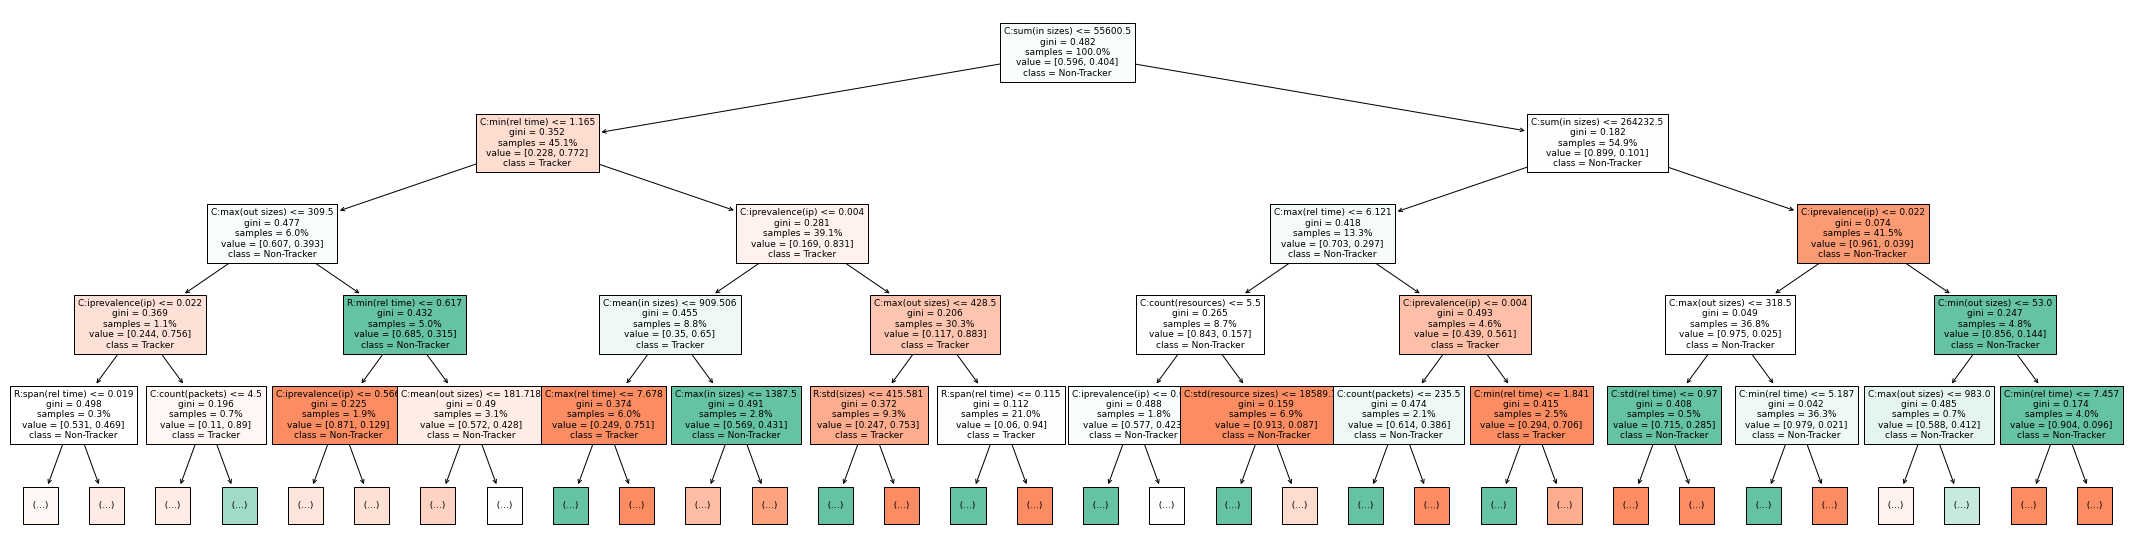

In [9]:
from sklearn import tree
from matplotlib.colors import ListedColormap, to_rgb


def visualize_tree(clf, feature_names, name):
    colors = sns.color_palette("Set2")
    
    x_size = min(int(2*2**clf.get_depth()), 38)
    y_size = min(clf.get_depth()*2, 10)
    fig = plt.figure(figsize=(x_size,y_size))
    artists = tree.plot_tree(clf, feature_names=feature_names, filled=True, class_names=['Non-Tracker', 'Tracker'], max_depth=4,
                            proportion=True, fontsize=9)

    for artist, impurity, value in zip(artists, clf.tree_.impurity, clf.tree_.value):
        # let the max value decide the color; whiten the color depending on impurity (gini)
        r, g, b = to_rgb(colors[np.argmax(value)])
        f = impurity * 2 # for N colors: f = impurity * N/(N-1) if N>1 else 0
        rgb = [max(0, min(f + (1-f)*c, 1)) for c in [r, g, b]]
        artist.get_bbox_patch().set_facecolor(rgb)
        artist.get_bbox_patch().set_edgecolor('black')

    fig.savefig(ASSETS / f"{name}{CHART_FILE_EXTENSION}")

visualize_tree(models[0], X_train.columns, f"{models[0]}_all_features")

### Cross-Validation (split by website)

In [10]:
def cross_validation_dataset(df, validation_size=0.1):
    rnd_websites = utils.shuffle(df['website_call'].unique().tolist())
    n_chunks = validation_size**-1
    test_website_chunks = np.array_split(rnd_websites, n_chunks)
    cross_val = []
    for test_websites in test_website_chunks:
        train = utils.shuffle(df[~df['website_call'].isin(test_websites)])
        test = utils.shuffle(df[df['website_call'].isin(test_websites)])
        cross_val.append([train, test])
    return cross_val

def cross_validate(df, validation_size=0.1):
    cross_val = cross_validation_dataset(df, validation_size)
    performances = {'DT': [], 'LR': []}
    for train, test in cross_val:
        X_train = X.loc[train.index]
        X_test = X.loc[test.index]
        y_train, y_test = train['is_tracker'], test['is_tracker']
        models = train_models(X_train, y_train)
        
        y_preds = [model.predict(X_test) for model in models]
        for name, model, y_pred in zip(['DT', 'LR'], models, y_preds):
            performances[name].append({'acc': accuracy_score(y_test, y_pred), 'f1': f1_score(y_test, y_pred)})
            
    return performances

cross_val = cross_validate(df, validation_size=0.2)

In [11]:
p_dt = pd.DataFrame(cross_val['DT']).mean()
p_lr = pd.DataFrame(cross_val['LR']).mean()
pd.DataFrame([p_dt, p_lr], index=['DT', 'LR'])

,acc,f1
DT,0.895973,0.870162
LR,0.850735,0.809973


### Performance for specific website

In [12]:
def evaluate_models_by_website(models, X_test, y_test, website, X_train=None, y_train=None, study_name=None):
    if study_name:
        webidx = df_test[(df_test['website_call'] == website) & (df_test['study_name'] == study_name)].index
    else:
        webidx = df_test[df_test['website_call'] == website].index
    
    for model in models:
        print(model)
        if X_train is not None and y_train is not None:
            print(f'model score on training data: {model.score(X_train, y_train)}')
        print(f'model score on testing data: {model.score(X_test, y_test)}')
        predictions = model.predict(X_test.loc[webidx])
        print(classification_report(y_test.loc[webidx], predictions, target_names=['Non-Tracker', 'Tracker']))
        tn, fp, fn, tp = confusion_matrix(y_test.loc[webidx], predictions).ravel()
        print(f"[tp={tp}, fp={fp}, fn={fn}, tn={tn}\n")

evaluate_models_by_website(models, X_test, y_test, 'nytimes.com', X_train, y_train, 'after accept')

DecisionTreeClassifier(max_depth=16)
model score on training data: 0.9832036708840427
model score on testing data: 0.8974718214750023
              precision    recall  f1-score   support

 Non-Tracker       0.98      0.99      0.98       346
     Tracker       0.90      0.85      0.87        53

    accuracy                           0.97       399
   macro avg       0.94      0.92      0.93       399
weighted avg       0.97      0.97      0.97       399

[tp=45, fp=5, fn=8, tn=341

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, penalty='l1',
                                    solver='liblinear'))])
model score on training data: 0.8514673363067351
model score on testing data: 0.8620924684766557
              precision    recall  f1-score   support

 Non-Tracker       0.97      0.99      0.98       346
     Tracker       0.89      0.79      0.84        53

    accuracy                          

### Difference between http and http2

In [13]:
for protocol in ['http', 'http2']:
    print(protocol)
    X_test_protocol = X_test.loc[df['protocol'] == protocol]
    y_test_protocol = y_test.loc[df['protocol'] == protocol]
    for model in models:
        print(model)
        predictions = model.predict(X_test_protocol)
        print(classification_report(y_test_protocol, predictions, target_names=['Non-Tracker', 'Tracker']))
        tn, fp, fn, tp = confusion_matrix(y_test_protocol, predictions).ravel()
        print(f"[tp={tp}, fp={fp}, fn={fn}, tn={tn}\n")


http
DecisionTreeClassifier(max_depth=16)
              precision    recall  f1-score   support

 Non-Tracker       0.90      0.83      0.86      4747
     Tracker       0.89      0.94      0.91      7059

    accuracy                           0.89     11806
   macro avg       0.90      0.88      0.89     11806
weighted avg       0.89      0.89      0.89     11806

[tp=6612, fp=802, fn=447, tn=3945

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, penalty='l1',
                                    solver='liblinear'))])
              precision    recall  f1-score   support

 Non-Tracker       0.92      0.80      0.85      4747
     Tracker       0.88      0.95      0.91      7059

    accuracy                           0.89     11806
   macro avg       0.90      0.87      0.88     11806
weighted avg       0.89      0.89      0.89     11806

[tp=6715, fp=957, fn=344, tn=3790

http2
DecisionTreeClas

### Difference between communication and resource features

In [14]:
def test_subfeatures(f_names):
    print(f"Only use subset of features: {f_names}")
    X_train_sub = X_train[f_names]
    X_test_sub = X_test[f_names]
    models_sub = train_models(X_train_sub, y_train)
    evaluate_models(models_sub, X_test_sub, y_test, X_train_sub, y_train)
    
    return models_sub

**Communication features only**

Only use subset of features: Index(['C:count(resources)', 'C:count(packets)', 'C:count(in packets)',
       'C:count(out packets)', 'C:mean(resource sizes)',
       'C:std(resource sizes)', 'C:min(resource sizes)',
       'C:max(resource sizes)', 'C:span(resource sizes)', 'C:sum(sizes)',
       'C:mean(sizes)', 'C:std(sizes)', 'C:min(sizes)', 'C:max(sizes)',
       'C:span(sizes)', 'C:sum(in sizes)', 'C:mean(in sizes)',
       'C:std(in sizes)', 'C:min(in sizes)', 'C:max(in sizes)',
       'C:span(in sizes)', 'C:sum(out sizes)', 'C:mean(out sizes)',
       'C:std(out sizes)', 'C:min(out sizes)', 'C:max(out sizes)',
       'C:span(out sizes)', 'C:mean(rel time)', 'C:std(rel time)',
       'C:min(rel time)', 'C:max(rel time)', 'C:span(rel time)',
       'C:sum(delta req time)', 'C:mean(delta req time)',
       'C:std(delta req time)', 'C:max(delta req time)', 'C:iprevalence(ip)'],
      dtype='object')
DecisionTreeClassifier(max_depth=9)
model score on training data: 0.9281297017139002
m

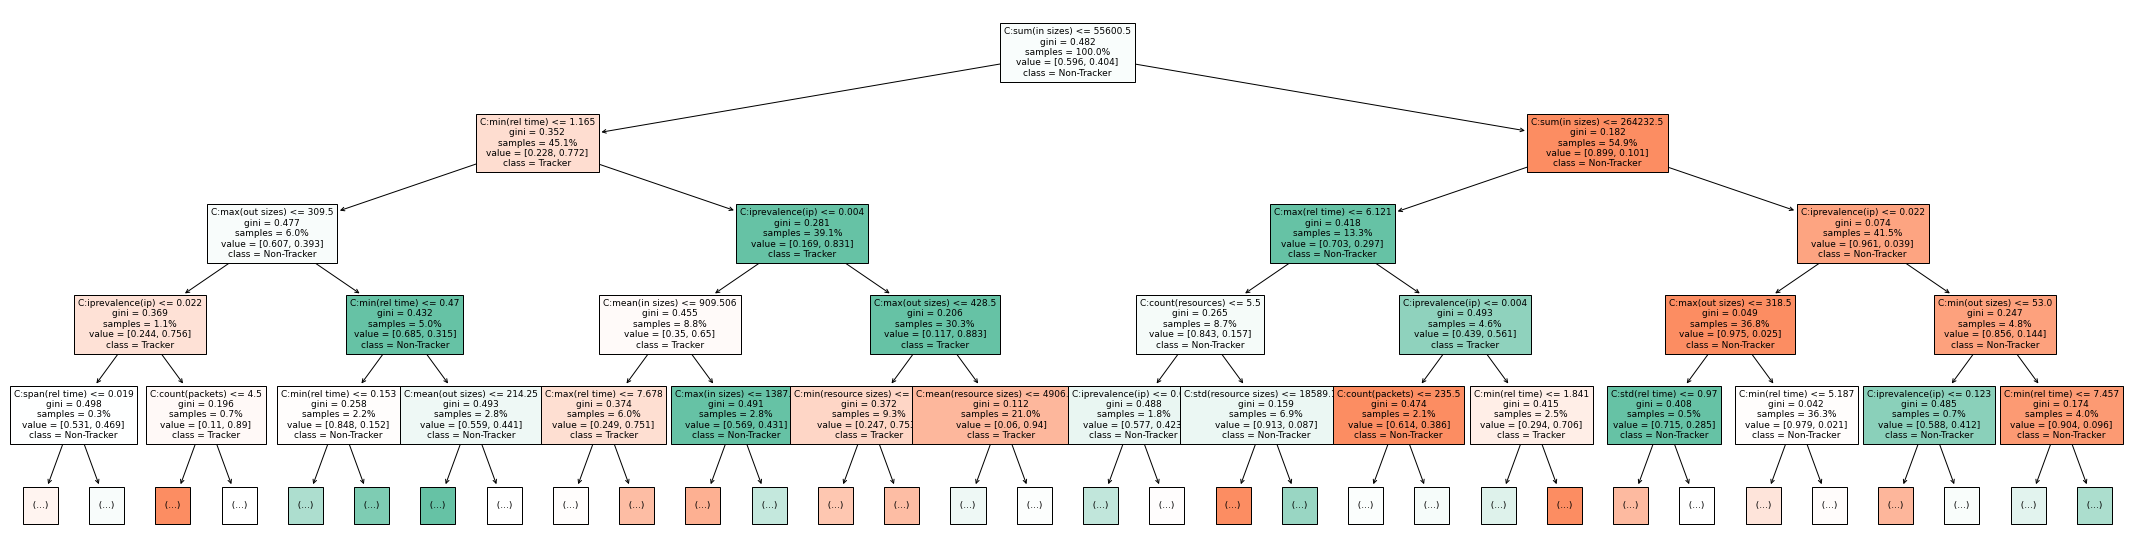

In [15]:
models_com = test_subfeatures(feature_names['communication'])
visualize_tree(models_com[0], feature_names['communication'], f"{models_com[0]}_com_features")

**Resource features only**

Only use subset of features: Index(['R:count(packets)', 'R:count(in packets)', 'R:count(out packets)',
       'R:sum(sizes)', 'R:mean(sizes)', 'R:std(sizes)', 'R:min(sizes)',
       'R:max(sizes)', 'R:span(sizes)', 'R:sum(in sizes)', 'R:mean(in sizes)',
       'R:std(in sizes)', 'R:min(in sizes)', 'R:max(in sizes)',
       'R:span(in sizes)', 'R:sum(out sizes)', 'R:mean(out sizes)',
       'R:std(out sizes)', 'R:min(out sizes)', 'R:max(out sizes)',
       'R:span(out sizes)', 'R:mean(rel time)', 'R:std(rel time)',
       'R:min(rel time)', 'R:max(rel time)', 'R:span(rel time)',
       'R:delta req time'],
      dtype='object')
DecisionTreeClassifier(max_depth=6)
model score on training data: 0.8536251050774495
model score on testing data: 0.8511744733487321
              precision    recall  f1-score   support

 Non-Tracker       0.89      0.87      0.88     49127
     Tracker       0.79      0.82      0.81     30100

    accuracy                           0.85     79227
   macro avg  

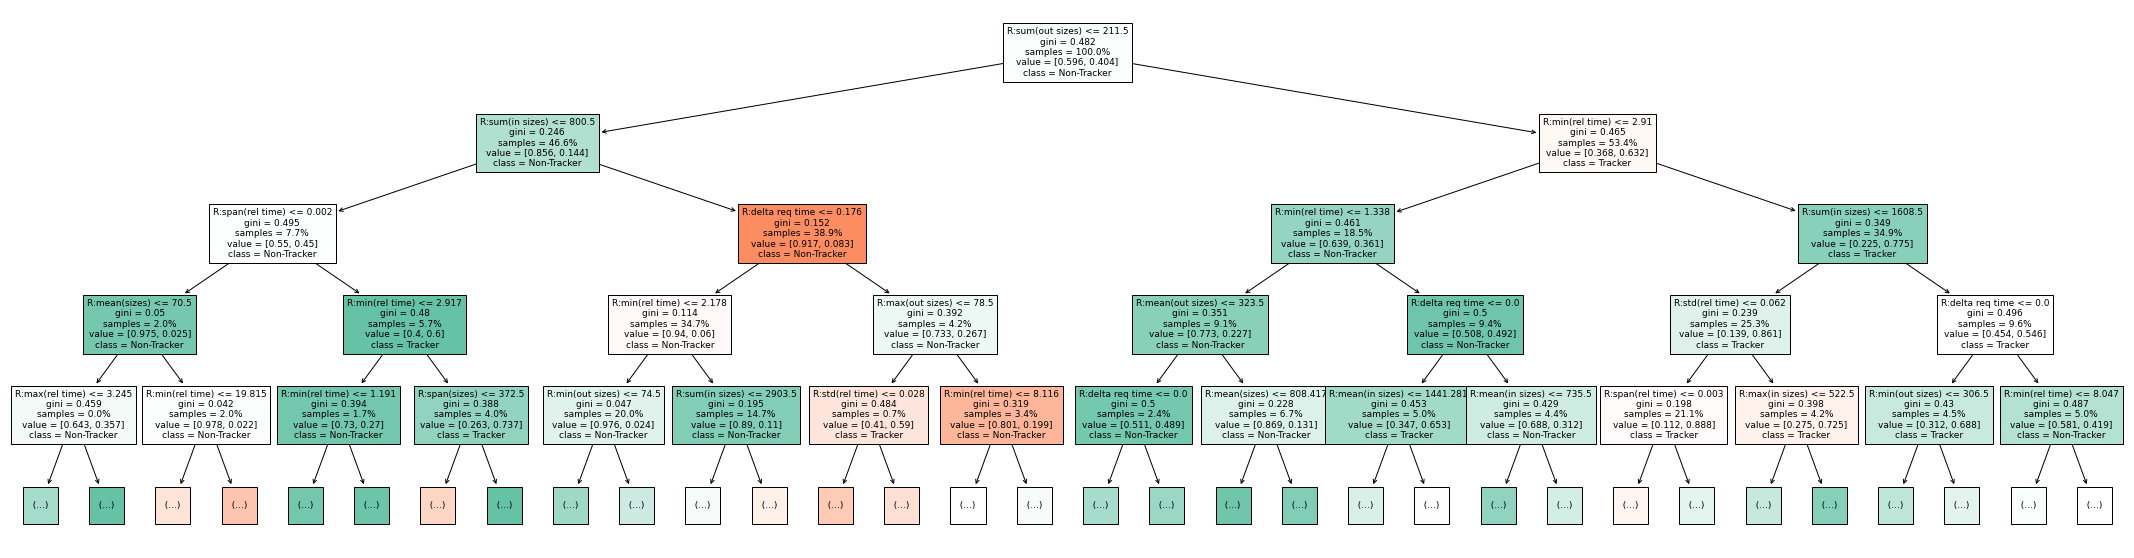

In [16]:
models_res = test_subfeatures(feature_names['resource'])
visualize_tree(models_res[0], feature_names['resource'], f"{models_res[0]}_res_features")

### Look at the data

#### Threshold 0.5

In [17]:
K = 5

for model in models:
    print(f"== {model} ==")
    predictions = model.predict(X_test)
    result = pd.concat([pd.DataFrame({'true': y_test, 'prediction': predictions}), df.iloc[X_test.index][['url', 'website_call']], X_test], axis=1)
    print("True Positive:")
    display(result[(result['true'] & result['prediction'])][result.columns[2:]].head(K))
    print("\nTrue Negative:")
    display(result[(~result['true'] & ~result['prediction'])][result.columns[2:]].head(K))
    print("\nFalse Positive:")
    display(result[(~result['true'] & result['prediction'])][result.columns[2:]].head(K))
    print("\nFalse Negative:")
    display(result[(result['true'] & ~result['prediction'])][result.columns[2:]].head(K))
    print()
    

== DecisionTreeClassifier(max_depth=16) ==
True Positive:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
235693,https://pm.w55c.net/ping_match.gif?scc=1&ei=CASALE&rurl=https://dsum-sec.casalemedia.com/crum?cm_dsp_id=47&external_user_id=_wfivefivec_&gdpr=1&gdpr_consent=CPiLUcAPiLUcAAcABBENCpCsAP_AAH_AACiQJHtf_X__b2_r-_5_f_t0eY1P9_7__-0zjhfdl-8N3f_X_L8X52M7vF36tq4KuR4ku3LBIUdlHOHcTUmw6okVryPsbk2cr7NKJ7PEmnMbOydYGH9_n1_z-ZKY7___f_7z_v-v___3____7-3f3__5___-__e_V__9zfn9_____9vP___9v-_9__________3_7997-CRoBJhq3EAXZljgzbRhFAiBGFYSHUCgAooBhaIDCB1cFOyuAn1hAgAQCgCcCIEOAKMGAQAACQBIREBIEeCAQAEQCAAEACoRCABjYBBYAWBgEAAoBoWKMUAQgSEGRARFKYEBUiQUG9lQglB_oaYQh1lgBQaP-KhARrIGKwIhIWDkOCJAS8WSB5ijfIARghQCiVCtRCAA.f_gAD_gAAAAA,tripadvisor.com,2,4,2,2,2314.000,52.000,2262,2366,104,4628,1157.000,47.969,1096,1228,132,2394.0,1197.000,31.000,1166.0,1228.0,62.0,2234,1117.000,21.000,1096,1138,42,10.215,0.047,10.162,10.268,0.106,0.094,0.047,0.047,0.094,0.016845,2,1,1,2366,1183.000,45.000,1138,1228,90,1228.0,1228.000,0.000,1228.0,1228.0,0.0,1138.0,1138.0,0.0,1138.0,1138.0,0.0,10.262,0.006,10.256,10.268,0.012,0.093941
239408,https://ib.adnxs.com/ut/v3/prebid,esquire.com,7,16,7,9,2015.143,489.564,1568,2893,1325,14106,881.625,337.981,347,1460,1113,7353.0,1050.429,86.923,854.0,1125.0,271.0,6753,750.333,397.241,347,1460,1113,7.979,0.947,6.803,9.496,2.693,2.667,0.381,0.570,1.543,0.010720,3,1,2,2661,887.000,454.979,347,1460,1113,854.0,854.000,0.000,854.0,854.0,0.0,1807.0,903.5,556.5,347.0,1460.0,1113.0,6.812,0.012,6.803,6.830,0.027,0.000000
59044,https://imasdk.googleapis.com/js/sdkloader/ima3.js,apnews.com,1,19,18,1,24212.000,0.000,24212,24212,0,24212,1274.316,359.194,279,1460,1181,23933.0,1329.611,279.453,419.0,1460.0,1041.0,279,279.000,0.000,279,279,0,3.385,0.015,3.339,3.400,0.061,0.000,0.000,0.000,0.000,0.053599,19,18,1,24212,1274.316,359.194,279,1460,1181,23933.0,1329.611,279.453,419.0,1460.0,1041.0,279.0,279.0,0.0,279.0,279.0,0.0,3.385,0.015,3.339,3.400,0.061,0.000000
59074,https://krk.kargo.com/api/v2/bid?json=%7B%22sessionId%22%3A%2223fe10e1-496e-4053-932e-72642a88e1b4%22%2C%22requestCount%22%3A0%2C%22timeout%22%3A550%2C%22currency%22%3A%22USD%22%2C%22cpmGranularity%22%3A1%2C%22timestamp%22%3A1667991932029%2C%22bidIDs%22%3A%7B%22_xjn1f26IIx-3%22%3A%22_xjn1f26IIx%22%2C%22_pnx2rd66cR-1%22%3A%22_pnx2rd66cR%22%7D%2C%22bidSizes%22%3A%7B%22_xjn1f26IIx-3%22%3A%5B%5B728%2C90%5D%2C%5B970%2C250%5D%5D%2C%22_pnx2rd66cR-1%22%3A%5B%5B300%2C250%5D%5D%7D%2C%22cpmRange%22%3A%7B%22floor%22%3A1%2C%22ceil%22%3A999999%7D%2C%22userIDs%22%3A%7B%22crbIDs%22%3A%7B%7D%2C%22usp%22%3A%221---%22%7D%2C%22pageURL%22%3A%22https%3A%2F%2Fapnews.com%2F%22%2C%22rawCRBLocalStorage%22%3Anull%7D,apnews.com,1,2,1,1,1902.000,0.000,1902,1902,0,1902,951.000,249.000,702,1200,498,702.0,702.000,0.000,702.0,702.0,0.0,1200,1200.000,0.000,1200,1200,0,3.730,0.013,3.716,3.743,0.027,0.000,0.000,0.000,0.000,0.004594,2,1,1,1902,951.000,249.000,702,1200,498,702.0,702.000,0.000,702.0,702.0,0.0,1200.0,1200.0,0.0,1200.0,


True Negative:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
251285,https://www.youtube.com/embed/xdQ9sgpkrX8,wireshark.org,6,51,45,6,10314.000,1408.071,7451,12084,4633,61884,1213.412,471.544,65,1460,1395,61154.0,1358.978,264.129,348.0,1460.0,1112.0,730,121.667,126.264,65,404,339,1.052,0.048,0.936,1.086,0.150,0.026,0.004,0.010,0.026,0.061256,9,8,1,10923,1213.667,446.745,65,1460,1395,10858.0,1357.250,197.441,878.0,1460.0,582.0,65.0,65.0,0.0,65.0,65.0,0.0,1.039,0.043,0.937,1.083,0.146,0.000057
96532,https://lww.com/_layouts/15/oaks.journals/core/ejp-print.css?v=05.09.00.105,lww.com,54,1844,1752,92,46517.815,87886.103,465,467947,467482,2511962,1362.235,315.976,23,1460,1437,2449342.0,1398.026,243.368,23.0,1460.0,1437.0,62620,680.652,619.918,24,1460,1436,1.493,0.737,0.045,4.702,4.657,4.633,0.086,0.198,0.792,-1.000000,2,1,1,617,308.500,191.500,117,500,383,500.0,500.000,0.000,500.0,500.0,0.0,117.0,117.0,0.0,117.0,117.0,0.0,1.411,0.047,1.364,1.458,0.094,0.000145
188656,https://assets-jpcust.jwpsrv.com/thumbnails/2wyo2zae-720.jpg,time.com,15,548,533,15,50307.267,68085.262,1042,275464,274422,754609,1377.024,288.938,7,1460,1453,751525.0,1409.991,209.939,7.0,1460.0,1453.0,3084,205.600,270.253,71,1144,1073,4.499,1.143,3.066,9.341,6.275,6.177,0.412,0.923,3.552,0.019908,49,48,1,69816,1424.816,198.093,73,1460,1387,69743.0,1452.979,34.555,1236.0,1460.0,224.0,73.0,73.0,0.0,73.0,73.0,0.0,3.440,0.002,3.427,3.442,0.015,0.000191
230519,https://nypost.com/wp-content/uploads/sites/2/2022/11/mexico-city1.jpg?quality=75&strip=all&w=744,nypost.com,116,1677,1557,120,19450.276,31109.015,187,238572,238385,2256232,1345.398,352.674,1,1460,1459,2217343.0,1424.112,176.867,1.0,1460.0,1459.0,38889,324.075,456.972,83,1460,1377,4.878,5.334,0.879,12.935,12.056,12.010,0.104,0.899,9.717,0.001531,18,17,1,24114,1339.667,351.883,109,1460,1351,24005.0,1412.059,191.765,645.0,1460.0,815.0,109.0,109.0,0.0,109.0,109.0,0.0,1.703,0.004,1.685,1.705,0.020,0.003562
237281,https://assets.tumblr.com/pop/js/modern/async-activity-popover-2f0b4678.js,tumblr.com,138,2652,2507,145,25540.333,130108.824,172,1476683,1476511,3524566,1329.022,366.429,9,1460,1451,3496367.0,1394.642,240.384,9.0,1460.0,1451.0,28199,194.476,308.286,61,1460,1399,8.143,4.635,0.120,15.158,15.038,15.018,0.109,0.284,1.726,-1.000000,6,5,1,6542,1090.333,544.716,86,1460,1374,6456.0,1291.200,337.600,616.0,1460.0,844.0,86.0,86.0,0.0,86.0,86.0,0.0,13.681,0.007,13.666,13.684,0.018,0.030070



False Positive:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
8428,https://www.baidu.com/img/PCtm_d9c8750bed0b3c7d089fa7d55720d6cf.png,baidu.com,14,47,30,17,3150.571,1989.974,1108,6964,5856,44108,938.468,498.530,36,1460,1424,29108.0,970.267,539.861,181.0,1460.0,1279.0,15000,882.353,409.709,36,1460,1424,5.212,1.248,2.056,7.425,5.369,5.097,0.364,0.485,1.691,-1.0,5,4,1,6438,1287.600,263.785,779,1460,681,5659.0,1414.75,78.375,1279.0,1460.0,181.0,779.0,779.000,0.000,779.0,779.0,0.0,3.961,0.107,3.747,4.015,0.268,1.690912
153344,https://www.alibabacloud.com/en,aliyun.com,7,39,32,7,5944.429,12677.574,547,36995,36448,41611,1066.949,533.171,65,1460,1395,40134.0,1254.188,380.634,465.0,1460.0,995.0,1477,211.000,169.005,65,560,495,2.142,0.658,1.761,3.897,2.136,2.120,0.303,0.416,0.994,-1.0,2,1,1,1034,517.000,43.000,474,560,86,474.0,474.00,0.000,474.0,474.0,0.0,560.0,560.000,0.000,560.0,560.0,0.0,1.771,0.011,1.761,1.782,0.021,0.000000
56833,https://s.pwt.soundcloud.com/ag/646297/clear.js?ci=646297&dt=6462971605583802699000&mo=2&pd=acc&spa=1,soundcloud.com,7,28,21,7,4059.143,3990.398,838,11506,10668,28414,1014.786,482.523,174,1460,1286,23265.0,1107.857,523.353,174.0,1460.0,1286.0,5149,735.571,75.326,664,867,203,2.062,0.502,1.423,2.772,1.349,1.311,0.187,0.182,0.549,-1.0,5,4,1,6457,1291.400,262.204,783,1460,677,5674.0,1418.50,71.880,1294.0,1460.0,166.0,783.0,783.000,0.000,783.0,783.0,0.0,1.458,0.018,1.423,1.467,0.044,0.000000
219491,https://www.gov.cn/govweb/xhtml/2016gov/images/zhengce/searchBtn20191218.png,www.gov.cn,130,761,631,130,6734.223,5252.433,1323,17832,16509,875449,1150.393,450.880,1,1460,1459,802032.0,1271.049,399.322,1.0,1460.0,1459.0,73417,564.746,49.172,473,832,359,12.873,2.005,8.056,18.074,10.018,9.121,0.070,0.223,2.104,-1.0,3,2,1,2318,772.667,498.181,295,1460,1165,1755.0,877.50,582.500,295.0,1460.0,1165.0,563.0,563.000,0.000,563.0,563.0,0.0,14.960,0.105,14.811,15.034,0.223,0.010899
234463,https://www.tripadvisor.com/data/graphql/ids,tripadvisor.com,21,300,240,60,18107.381,41463.169,1932,186547,184615,380255,1267.517,372.225,55,1460,1405,321001.0,1337.504,296.872,70.0,1460.0,1390.0,59254,987.567,492.197,55,1460,1405,6.393,5.090,0.243,12.199,11.956,11.845,0.564,0.975,4.162,-1.0,4,1,3,3250,812.500,466.991,304,1460,1156,1047.0,1047.00,0.000,1047.0,1047.0,0.0,2203.0,734.333,516.075,304.0,1460.0,1156.0,2.463,0.063,2.426,2.572,0.146,0.082935



False Negative:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
74383,https://tm.hdmtools.com/hearst/news/code/aa26cb7b1115b5862b84639e515ac142.js?conditionId0=4908953,chron.com,11,79,68,11,8108.364,9687.351,498,28094,27596,89192,1129.013,516.506,59,1460,1401,87611.0,1288.397,356.043,59.0,1460.0,1401.0,1581,143.727,66.948,103,296,193,1.297,0.416,0.586,1.998,1.412,1.398,0.127,0.208,0.515,0.003063,6,5,1,7286,1214.333,498.008,105,1460,1355,7181.0,1436.2,47.600,1341.0,1460.0,119.0,105.0,105.0,0.000,105.0,105.0,0.0,1.524,0.006,1.512,1.527,0.015,0.000189
2751,https://gov1.siteintercept.qualtrics.com/WRQualtricsShared/Graphics/siteintercept/remove_screen_capture.png,hhs.gov,29,505,472,33,22777.069,45398.109,637,223217,222580,660535,1307.990,392.106,19,1460,1441,655339.0,1388.430,254.919,19.0,1460.0,1441.0,5196,157.455,84.027,82,416,334,3.303,0.282,2.384,3.809,1.425,1.406,0.048,0.060,0.220,0.001531,3,2,1,1625,541.667,649.499,66,1460,1394,1526.0,763.0,697.000,66.0,1460.0,1394.0,99.0,99.0,0.000,99.0,99.0,0.0,3.803,0.009,3.790,3.809,0.019,0.000043
28267,https://tags.srv.stackadapt.com/sa.jpeg,theglobeandmail.com,4,12,8,4,2638.250,2204.860,1014,6435,5421,10553,879.417,486.107,115,1460,1345,7665.0,958.125,542.699,115.0,1460.0,1345.0,2888,722.000,287.549,480,1200,720,4.501,1.903,2.566,7.434,4.868,4.638,1.159,1.181,3.048,0.001531,2,1,1,1425,712.500,197.500,515,910,395,910.0,910.0,0.000,910.0,910.0,0.0,515.0,515.0,0.000,515.0,515.0,0.0,6.016,0.057,5.959,6.074,0.115,0.345071
186339,https://service.maxymiser.net/cm/images-eu/kaspersky-com/D2DD7DF96FFB456801CDCD276F83D9A7E526E6002080BE989334BFC7553BE7EA.svg?meta=/BB-DE-SW-Soft-Launch-V5-new-legals/Color.svg,kaspersky.com,21,511,490,21,32107.476,38654.914,1009,121495,120486,674257,1319.485,354.017,33,1460,1427,669971.0,1367.288,273.159,33.0,1460.0,1427.0,4286,204.095,105.860,78,515,437,3.234,0.806,0.172,3.637,3.465,3.450,0.164,0.503,2.319,-1.000000,11,10,1,13181,1198.273,454.521,164,1460,1296,13017.0,1301.7,331.027,396.0,1460.0,1064.0,164.0,164.0,0.000,164.0,164.0,0.0,3.524,0.004,3.512,3.525,0.013,0.000158
111224,https://prg.smartadserver.com/prebid/v1,dailymail.co.uk,14,56,14,42,4514.071,26.391,4484,4574,90,63197,1128.518,451.938,363,1460,1097,5082.0,363.000,0.000,363.0,363.0,0.0,58115,1383.690,108.988,1201,1460,259,3.505,0.927,3.202,6.827,3.625,3.602,0.257,0.907,3.528,-1.000000,4,1,3,4506,1126.500,451.301,363,1460,1097,363.0,363.0,0.000,363.0,363.0,0.0,4143.0,1381.0,111.723,1223.0,1460.0,237.0,3.232,0.009,3.226,3.247,0.021,0.021015



== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, penalty='l1',
                                    solver='liblinear'))]) ==
True Positive:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
235693,https://pm.w55c.net/ping_match.gif?scc=1&ei=CASALE&rurl=https://dsum-sec.casalemedia.com/crum?cm_dsp_id=47&external_user_id=_wfivefivec_&gdpr=1&gdpr_consent=CPiLUcAPiLUcAAcABBENCpCsAP_AAH_AACiQJHtf_X__b2_r-_5_f_t0eY1P9_7__-0zjhfdl-8N3f_X_L8X52M7vF36tq4KuR4ku3LBIUdlHOHcTUmw6okVryPsbk2cr7NKJ7PEmnMbOydYGH9_n1_z-ZKY7___f_7z_v-v___3____7-3f3__5___-__e_V__9zfn9_____9vP___9v-_9__________3_7997-CRoBJhq3EAXZljgzbRhFAiBGFYSHUCgAooBhaIDCB1cFOyuAn1hAgAQCgCcCIEOAKMGAQAACQBIREBIEeCAQAEQCAAEACoRCABjYBBYAWBgEAAoBoWKMUAQgSEGRARFKYEBUiQUG9lQglB_oaYQh1lgBQaP-KhARrIGKwIhIWDkOCJAS8WSB5ijfIARghQCiVCtRCAA.f_gAD_gAAAAA,tripadvisor.com,2,4,2,2,2314.000,52.000,2262,2366,104,4628,1157.000,47.969,1096,1228,132,2394.0,1197.000,31.000,1166.0,1228.0,62.0,2234,1117.000,21.000,1096,1138,42,10.215,0.047,10.162,10.268,0.106,0.094,0.047,0.047,0.094,0.016845,2,1,1,2366,1183.000,45.000,1138,1228,90,1228.0,1228.0,0.0,1228.0,1228.0,0.0,1138.0,1138.0,0.0,1138.0,1138.0,0.0,10.262,0.006,10.256,10.268,0.012,0.093941
239408,https://ib.adnxs.com/ut/v3/prebid,esquire.com,7,16,7,9,2015.143,489.564,1568,2893,1325,14106,881.625,337.981,347,1460,1113,7353.0,1050.429,86.923,854.0,1125.0,271.0,6753,750.333,397.241,347,1460,1113,7.979,0.947,6.803,9.496,2.693,2.667,0.381,0.570,1.543,0.010720,3,1,2,2661,887.000,454.979,347,1460,1113,854.0,854.0,0.0,854.0,854.0,0.0,1807.0,903.5,556.5,347.0,1460.0,1113.0,6.812,0.012,6.803,6.830,0.027,0.000000
59074,https://krk.kargo.com/api/v2/bid?json=%7B%22sessionId%22%3A%2223fe10e1-496e-4053-932e-72642a88e1b4%22%2C%22requestCount%22%3A0%2C%22timeout%22%3A550%2C%22currency%22%3A%22USD%22%2C%22cpmGranularity%22%3A1%2C%22timestamp%22%3A1667991932029%2C%22bidIDs%22%3A%7B%22_xjn1f26IIx-3%22%3A%22_xjn1f26IIx%22%2C%22_pnx2rd66cR-1%22%3A%22_pnx2rd66cR%22%7D%2C%22bidSizes%22%3A%7B%22_xjn1f26IIx-3%22%3A%5B%5B728%2C90%5D%2C%5B970%2C250%5D%5D%2C%22_pnx2rd66cR-1%22%3A%5B%5B300%2C250%5D%5D%7D%2C%22cpmRange%22%3A%7B%22floor%22%3A1%2C%22ceil%22%3A999999%7D%2C%22userIDs%22%3A%7B%22crbIDs%22%3A%7B%7D%2C%22usp%22%3A%221---%22%7D%2C%22pageURL%22%3A%22https%3A%2F%2Fapnews.com%2F%22%2C%22rawCRBLocalStorage%22%3Anull%7D,apnews.com,1,2,1,1,1902.000,0.000,1902,1902,0,1902,951.000,249.000,702,1200,498,702.0,702.000,0.000,702.0,702.0,0.0,1200,1200.000,0.000,1200,1200,0,3.730,0.013,3.716,3.743,0.027,0.000,0.000,0.000,0.000,0.004594,2,1,1,1902,951.000,249.000,702,1200,498,702.0,702.0,0.0,702.0,702.0,0.0,1200.0,1200.0,0.0,1200.0,1200.0,0.0,3.730,0.013,3.716,3.743,0.027,0.000000
123557,https://htlb.casalemedia.com/openrtb/pbjs?s=823166&v=7.2&ac=j&sd=1&r=%7B%22id%22%3A%227cdaec1d601483%22%2C%22site%22%3A%7B%22page%22%3A%22https%3A%2F%2Fwww.thedailybeast.com%2F%22%7D%2C%22ext%22%3A%7B%22source%22%3A%22prebid%22%2C%22ixdiag%22%3A%7B%22msd%22%3A4%2C%22msi%22%3A4%2C%22mfu%22%3A0%2C%22bu%22%3A2%2C%22iu%22%3A0%2C%22nu%22%3A0%2C%22ou%22%3A0%2C%22allu%22%3A2%2C%22ren%22%3Afalse%2C%22v


True Negative:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
251285,https://www.youtube.com/embed/xdQ9sgpkrX8,wireshark.org,6,51,45,6,10314.000,1408.071,7451,12084,4633,61884,1213.412,471.544,65,1460,1395,61154.0,1358.978,264.129,348.0,1460.0,1112.0,730,121.667,126.264,65,404,339,1.052,0.048,0.936,1.086,0.150,0.026,0.004,0.010,0.026,0.061256,9,8,1,10923,1213.667,446.745,65,1460,1395,10858.0,1357.250,197.441,878.0,1460.0,582.0,65.0,65.0,0.0,65.0,65.0,0.0,1.039,0.043,0.937,1.083,0.146,0.000057
96532,https://lww.com/_layouts/15/oaks.journals/core/ejp-print.css?v=05.09.00.105,lww.com,54,1844,1752,92,46517.815,87886.103,465,467947,467482,2511962,1362.235,315.976,23,1460,1437,2449342.0,1398.026,243.368,23.0,1460.0,1437.0,62620,680.652,619.918,24,1460,1436,1.493,0.737,0.045,4.702,4.657,4.633,0.086,0.198,0.792,-1.000000,2,1,1,617,308.500,191.500,117,500,383,500.0,500.000,0.000,500.0,500.0,0.0,117.0,117.0,0.0,117.0,117.0,0.0,1.411,0.047,1.364,1.458,0.094,0.000145
188656,https://assets-jpcust.jwpsrv.com/thumbnails/2wyo2zae-720.jpg,time.com,15,548,533,15,50307.267,68085.262,1042,275464,274422,754609,1377.024,288.938,7,1460,1453,751525.0,1409.991,209.939,7.0,1460.0,1453.0,3084,205.600,270.253,71,1144,1073,4.499,1.143,3.066,9.341,6.275,6.177,0.412,0.923,3.552,0.019908,49,48,1,69816,1424.816,198.093,73,1460,1387,69743.0,1452.979,34.555,1236.0,1460.0,224.0,73.0,73.0,0.0,73.0,73.0,0.0,3.440,0.002,3.427,3.442,0.015,0.000191
230519,https://nypost.com/wp-content/uploads/sites/2/2022/11/mexico-city1.jpg?quality=75&strip=all&w=744,nypost.com,116,1677,1557,120,19450.276,31109.015,187,238572,238385,2256232,1345.398,352.674,1,1460,1459,2217343.0,1424.112,176.867,1.0,1460.0,1459.0,38889,324.075,456.972,83,1460,1377,4.878,5.334,0.879,12.935,12.056,12.010,0.104,0.899,9.717,0.001531,18,17,1,24114,1339.667,351.883,109,1460,1351,24005.0,1412.059,191.765,645.0,1460.0,815.0,109.0,109.0,0.0,109.0,109.0,0.0,1.703,0.004,1.685,1.705,0.020,0.003562
237281,https://assets.tumblr.com/pop/js/modern/async-activity-popover-2f0b4678.js,tumblr.com,138,2652,2507,145,25540.333,130108.824,172,1476683,1476511,3524566,1329.022,366.429,9,1460,1451,3496367.0,1394.642,240.384,9.0,1460.0,1451.0,28199,194.476,308.286,61,1460,1399,8.143,4.635,0.120,15.158,15.038,15.018,0.109,0.284,1.726,-1.000000,6,5,1,6542,1090.333,544.716,86,1460,1374,6456.0,1291.200,337.600,616.0,1460.0,844.0,86.0,86.0,0.0,86.0,86.0,0.0,13.681,0.007,13.666,13.684,0.018,0.030070



False Positive:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
159508,https://www.google.com/recaptcha/api2/aframe,hindustantimes.com,1,3,2,1,2099.0,0.0,2099,2099,0,2099,699.667,539.827,260,1460,1200,1720.0,860.0,600.000,260.0,1460.0,1200.0,379,379.0,0.0,379,379,0,6.194,0.009,6.182,6.201,0.019,0.0,0.0,0.0,0.0,0.548239,3,2,1,2099,699.667,539.827,260,1460,1200,1720.0,860.000,600.000,260.0,1460.0,1200.0,379.0,379.0,0.0,379.0,379.0,0.0,6.194,0.009,6.182,6.201,0.019,0.000000
235644,https://69defd5b75fbb59ec73ba72f51c5b1ae.safeframe.googlesyndication.com/safeframe/1-0-39/html/container.html,tripadvisor.com,1,4,3,1,4094.0,0.0,4094,4094,0,4094,1023.500,451.824,422,1460,1038,3672.0,1224.0,333.754,752.0,1460.0,708.0,422,422.0,0.0,422,422,0,8.858,0.007,8.846,8.862,0.016,0.0,0.0,0.0,0.0,0.179173,4,3,1,4094,1023.500,451.824,422,1460,1038,3672.0,1224.000,333.754,752.0,1460.0,708.0,422.0,422.0,0.0,422.0,422.0,0.0,8.858,0.007,8.846,8.862,0.016,0.000000
232713,https://cosmopolitan.com/,cosmopolitan.com,1,2,1,1,1057.0,0.0,1057,1057,0,1057,528.500,222.500,306,751,445,306.0,306.0,0.000,306.0,306.0,0.0,751,751.0,0.0,751,751,0,0.029,0.004,0.025,0.032,0.007,0.0,0.0,0.0,0.0,-1.000000,2,1,1,1057,528.500,222.500,306,751,445,306.0,306.000,0.000,306.0,306.0,0.0,751.0,751.0,0.0,751.0,751.0,0.0,0.029,0.004,0.025,0.032,0.007,0.000000
51308,https://fonts.gstatic.com/s/roboto/v30/KFOlCnqEu92Fr1MmWUlfBBc4.woff2,science.org,2,7,5,2,3347.0,93.0,3254,3440,186,6694,956.286,589.387,87,1460,1373,6273.0,1254.6,410.800,433.0,1460.0,1027.0,421,210.5,123.5,87,334,247,6.014,0.005,6.007,6.021,0.014,0.0,0.0,0.0,0.0,0.316998,4,3,1,3440,860.000,612.343,87,1460,1373,3353.0,1117.667,484.132,433.0,1460.0,1027.0,87.0,87.0,0.0,87.0,87.0,0.0,6.016,0.006,6.007,6.021,0.014,0.000048
260883,https://geolocation.onetrust.com/cookieconsentpub/v1/geo/location,broadcom.com,1,2,1,1,696.0,0.0,696,696,0,696,348.000,7.000,341,355,14,355.0,355.0,0.000,355.0,355.0,0.0,341,341.0,0.0,341,341,0,1.411,0.015,1.396,1.426,0.030,0.0,0.0,0.0,0.0,0.139357,2,1,1,696,348.000,7.000,341,355,14,355.0,355.000,0.000,355.0,355.0,0.0,341.0,341.0,0.0,341.0,341.0,0.0,1.411,0.015,1.396,1.426,0.030,0.000000



False Negative:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
74383,https://tm.hdmtools.com/hearst/news/code/aa26cb7b1115b5862b84639e515ac142.js?conditionId0=4908953,chron.com,11,79,68,11,8108.364,9687.351,498,28094,27596,89192,1129.013,516.506,59,1460,1401,87611.0,1288.397,356.043,59.0,1460.0,1401.0,1581,143.727,66.948,103,296,193,1.297,0.416,0.586,1.998,1.412,1.398,0.127,0.208,0.515,0.003063,6,5,1,7286,1214.333,498.008,105,1460,1355,7181.0,1436.200,47.600,1341.0,1460.0,119.0,105.0,105.0,0.0,105.0,105.0,0.0,1.524,0.006,1.512,1.527,0.015,0.000189
59044,https://imasdk.googleapis.com/js/sdkloader/ima3.js,apnews.com,1,19,18,1,24212.000,0.000,24212,24212,0,24212,1274.316,359.194,279,1460,1181,23933.0,1329.611,279.453,419.0,1460.0,1041.0,279,279.000,0.000,279,279,0,3.385,0.015,3.339,3.400,0.061,0.000,0.000,0.000,0.000,0.053599,19,18,1,24212,1274.316,359.194,279,1460,1181,23933.0,1329.611,279.453,419.0,1460.0,1041.0,279.0,279.0,0.0,279.0,279.0,0.0,3.385,0.015,3.339,3.400,0.061,0.000000
2751,https://gov1.siteintercept.qualtrics.com/WRQualtricsShared/Graphics/siteintercept/remove_screen_capture.png,hhs.gov,29,505,472,33,22777.069,45398.109,637,223217,222580,660535,1307.990,392.106,19,1460,1441,655339.0,1388.430,254.919,19.0,1460.0,1441.0,5196,157.455,84.027,82,416,334,3.303,0.282,2.384,3.809,1.425,1.406,0.048,0.060,0.220,0.001531,3,2,1,1625,541.667,649.499,66,1460,1394,1526.0,763.000,697.000,66.0,1460.0,1394.0,99.0,99.0,0.0,99.0,99.0,0.0,3.803,0.009,3.790,3.809,0.019,0.000043
136564,https://px.moatads.com/pixel.gif?e=31&hp=1&wf=1&ra=5&pxm=3&sgs=6&vb=19&kq=1&lo=0&uk=null&pk=0&wk=0&rk=1&tk=0&ak=-&i=CORUS_HEADER1&ol=0&qn=%604%7BZEYwoqI%24%5BK%2BdLLU)%2CMm~tM!90vv9L%24%2FoDb%2FG)lKr%23l9jmUdTfN%5Bqir1fcSC%3AU%3FWOvTh%7CzFK%3F%5B%22l!j%3F%5DQB3%2ByerEd%5E95SpGl)17*7*7UO0%40M%7CQDt%3ExZq%224%7CQjw%60.%7Bi%3F%5DQZ%2CA2%2BNhloI%40s1%7CZ5*%3FVl%3Fe3%7CqL5%40J%3D%5B98WimP%3DK2%2B1p%23Vn!9.aS%3B4oD%7D%60%3Fjc!L2LmqMs%3Cex1bxNTK7%2BuCTpY%3CZ.T%5B%2B%22gbzbSSr1r4V%40bLwA&tf=1_nMzjG---CSa7H-nHVQZC-bW7qhB-LRwqH-nMzjG-&vi=111111&rc=0%2C2%2C2%2C0%2C0%2C1%2C0%2C0%2Cprobably%2Cprobably&rb=1-dgUexhkHGpK4fCGFDVJ8vAq%2BUZ%2FvKDL4IjtFOewYCG7c8ePmuvZ6rDGw&rs=1-H141M1%2F1Kg7M0g%3D%3D&sc=1&os=1-Ng%3D%3D&qp=00000&is=&iv=8&qt=0&gz=0&hh=0&hn=0&tw=&qc=0&qd=0&qf=1920&qe=1080&qh=1920&qg=1080&qm=0&qa=1920&qb=1080&qi=1920&qj=1080&to=000&po=1-0020002000002120&vy=ot%24b%5Bh%40%22oDgO%3DLlE6%3ABcmUZzCFV%60pT6yv%7CEkUpF%3D3%3Ch%2C%25%3BMB1_tNOC%604dEzbSIq11_iCTpXSe%2BShooUKV%3B%2B9%7CPQPmf)P%3DH%3BCH%6029YCN%3FAbcE%3DX7IL3kQ%2CNJJ)%2Cc%7ClTr1W*d%5B4kf%2FLyUoRdByZ%3C99Ksf%2FLyUo0)H&qr=0&ql=&qo=0&vf=1&vg=100&bq=11&g=2&fl=1&j=&xc=0&xb=0&xa=0&md=31&mc=0&lb=9511&ld=2970&lc=0&la=0&cw=1920&cx=1080&sh=9511&sr=0&sb=0&sq=0&sa=0&sn=816&sj=1712&sm=0&si=0&h=4&w=4&hq=0&hs=0&hu=0&hr=0&ht=0&dnt=0&rm=1&zGSRC=1&gu=https%3A%2F%2Fglobalnews.ca%2F&id=1&ii=4&cm=1&zMoatIS=0&pl=1&f=0&t=1668004595900&de=881454346103&rx=882061670997&cu=1668004595932&m=6761&ar=488

#### Specific threshold

In [18]:
def look_at_data(models, X_test, y_test, K=5, threshold=.5):
    for model in models:
        print(f"== {model} ==")
        predictions = np.apply_along_axis(lambda x: True if x[1] >= threshold else False, axis=1, arr=model.predict_proba(X_test))
        result = pd.concat([pd.DataFrame({'true': y_test, 'prediction': predictions}), df.iloc[X_test.index][['url', 'website_call']], X_test], axis=1)
        print("True Positive:")
        display(result[(result['true'] & result['prediction'])][result.columns[2:]].head(K))
        print("\nTrue Negative:")
        display(result[(~result['true'] & ~result['prediction'])][result.columns[2:]].head(K))
        print("\nFalse Positive:")
        display(result[(~result['true'] & result['prediction'])][result.columns[2:]].head(K))
        print("\nFalse Negative:")
        display(result[(result['true'] & ~result['prediction'])][result.columns[2:]].head(K))
        print()
        
look_at_data(models, X_test, y_test, K=10, threshold=0.7)

== DecisionTreeClassifier(max_depth=16) ==
True Positive:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
235693,https://pm.w55c.net/ping_match.gif?scc=1&ei=CASALE&rurl=https://dsum-sec.casalemedia.com/crum?cm_dsp_id=47&external_user_id=_wfivefivec_&gdpr=1&gdpr_consent=CPiLUcAPiLUcAAcABBENCpCsAP_AAH_AACiQJHtf_X__b2_r-_5_f_t0eY1P9_7__-0zjhfdl-8N3f_X_L8X52M7vF36tq4KuR4ku3LBIUdlHOHcTUmw6okVryPsbk2cr7NKJ7PEmnMbOydYGH9_n1_z-ZKY7___f_7z_v-v___3____7-3f3__5___-__e_V__9zfn9_____9vP___9v-_9__________3_7997-CRoBJhq3EAXZljgzbRhFAiBGFYSHUCgAooBhaIDCB1cFOyuAn1hAgAQCgCcCIEOAKMGAQAACQBIREBIEeCAQAEQCAAEACoRCABjYBBYAWBgEAAoBoWKMUAQgSEGRARFKYEBUiQUG9lQglB_oaYQh1lgBQaP-KhARrIGKwIhIWDkOCJAS8WSB5ijfIARghQCiVCtRCAA.f_gAD_gAAAAA,tripadvisor.com,2,4,2,2,2314.000,52.000,2262,2366,104,4628,1157.000,47.969,1096,1228,132,2394.0,1197.000,31.000,1166.0,1228.0,62.0,2234,1117.000,21.000,1096,1138,42,10.215,0.047,10.162,10.268,0.106,0.094,0.047,0.047,0.094,0.016845,2,1,1,2366,1183.000,45.000,1138,1228,90,1228.0,1228.000,0.000,1228.0,1228.0,0.0,1138.0,1138.0,0.0,1138.0,1138.0,0.0,10.262,0.006,10.256,10.268,0.012,0.093941
239408,https://ib.adnxs.com/ut/v3/prebid,esquire.com,7,16,7,9,2015.143,489.564,1568,2893,1325,14106,881.625,337.981,347,1460,1113,7353.0,1050.429,86.923,854.0,1125.0,271.0,6753,750.333,397.241,347,1460,1113,7.979,0.947,6.803,9.496,2.693,2.667,0.381,0.570,1.543,0.010720,3,1,2,2661,887.000,454.979,347,1460,1113,854.0,854.000,0.000,854.0,854.0,0.0,1807.0,903.5,556.5,347.0,1460.0,1113.0,6.812,0.012,6.803,6.830,0.027,0.000000
59044,https://imasdk.googleapis.com/js/sdkloader/ima3.js,apnews.com,1,19,18,1,24212.000,0.000,24212,24212,0,24212,1274.316,359.194,279,1460,1181,23933.0,1329.611,279.453,419.0,1460.0,1041.0,279,279.000,0.000,279,279,0,3.385,0.015,3.339,3.400,0.061,0.000,0.000,0.000,0.000,0.053599,19,18,1,24212,1274.316,359.194,279,1460,1181,23933.0,1329.611,279.453,419.0,1460.0,1041.0,279.0,279.0,0.0,279.0,279.0,0.0,3.385,0.015,3.339,3.400,0.061,0.000000
59074,https://krk.kargo.com/api/v2/bid?json=%7B%22sessionId%22%3A%2223fe10e1-496e-4053-932e-72642a88e1b4%22%2C%22requestCount%22%3A0%2C%22timeout%22%3A550%2C%22currency%22%3A%22USD%22%2C%22cpmGranularity%22%3A1%2C%22timestamp%22%3A1667991932029%2C%22bidIDs%22%3A%7B%22_xjn1f26IIx-3%22%3A%22_xjn1f26IIx%22%2C%22_pnx2rd66cR-1%22%3A%22_pnx2rd66cR%22%7D%2C%22bidSizes%22%3A%7B%22_xjn1f26IIx-3%22%3A%5B%5B728%2C90%5D%2C%5B970%2C250%5D%5D%2C%22_pnx2rd66cR-1%22%3A%5B%5B300%2C250%5D%5D%7D%2C%22cpmRange%22%3A%7B%22floor%22%3A1%2C%22ceil%22%3A999999%7D%2C%22userIDs%22%3A%7B%22crbIDs%22%3A%7B%7D%2C%22usp%22%3A%221---%22%7D%2C%22pageURL%22%3A%22https%3A%2F%2Fapnews.com%2F%22%2C%22rawCRBLocalStorage%22%3Anull%7D,apnews.com,1,2,1,1,1902.000,0.000,1902,1902,0,1902,951.000,249.000,702,1200,498,702.0,702.000,0.000,702.0,702.0,0.0,1200,1200.000,0.000,1200,1200,0,3.730,0.013,3.716,3.743,0.027,0.000,0.000,0.000,0.000,0.004594,2,1,1,1902,951.000,249.000,702,1200,498,702.0,702.000,0.000,702.0,702.0,0.0,1200.0,1200.0,0.0,1200.0,


True Negative:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
251285,https://www.youtube.com/embed/xdQ9sgpkrX8,wireshark.org,6,51,45,6,10314.000,1408.071,7451,12084,4633,61884,1213.412,471.544,65,1460,1395,61154.0,1358.978,264.129,348.0,1460.0,1112.0,730,121.667,126.264,65,404,339,1.052,0.048,0.936,1.086,0.150,0.026,0.004,0.010,0.026,0.061256,9,8,1,10923,1213.667,446.745,65,1460,1395,10858.0,1357.250,197.441,878.0,1460.0,582.0,65.0,65.0,0.0,65.0,65.0,0.0,1.039,0.043,0.937,1.083,0.146,0.000057
96532,https://lww.com/_layouts/15/oaks.journals/core/ejp-print.css?v=05.09.00.105,lww.com,54,1844,1752,92,46517.815,87886.103,465,467947,467482,2511962,1362.235,315.976,23,1460,1437,2449342.0,1398.026,243.368,23.0,1460.0,1437.0,62620,680.652,619.918,24,1460,1436,1.493,0.737,0.045,4.702,4.657,4.633,0.086,0.198,0.792,-1.000000,2,1,1,617,308.500,191.500,117,500,383,500.0,500.000,0.000,500.0,500.0,0.0,117.0,117.0,0.0,117.0,117.0,0.0,1.411,0.047,1.364,1.458,0.094,0.000145
188656,https://assets-jpcust.jwpsrv.com/thumbnails/2wyo2zae-720.jpg,time.com,15,548,533,15,50307.267,68085.262,1042,275464,274422,754609,1377.024,288.938,7,1460,1453,751525.0,1409.991,209.939,7.0,1460.0,1453.0,3084,205.600,270.253,71,1144,1073,4.499,1.143,3.066,9.341,6.275,6.177,0.412,0.923,3.552,0.019908,49,48,1,69816,1424.816,198.093,73,1460,1387,69743.0,1452.979,34.555,1236.0,1460.0,224.0,73.0,73.0,0.0,73.0,73.0,0.0,3.440,0.002,3.427,3.442,0.015,0.000191
230519,https://nypost.com/wp-content/uploads/sites/2/2022/11/mexico-city1.jpg?quality=75&strip=all&w=744,nypost.com,116,1677,1557,120,19450.276,31109.015,187,238572,238385,2256232,1345.398,352.674,1,1460,1459,2217343.0,1424.112,176.867,1.0,1460.0,1459.0,38889,324.075,456.972,83,1460,1377,4.878,5.334,0.879,12.935,12.056,12.010,0.104,0.899,9.717,0.001531,18,17,1,24114,1339.667,351.883,109,1460,1351,24005.0,1412.059,191.765,645.0,1460.0,815.0,109.0,109.0,0.0,109.0,109.0,0.0,1.703,0.004,1.685,1.705,0.020,0.003562
237281,https://assets.tumblr.com/pop/js/modern/async-activity-popover-2f0b4678.js,tumblr.com,138,2652,2507,145,25540.333,130108.824,172,1476683,1476511,3524566,1329.022,366.429,9,1460,1451,3496367.0,1394.642,240.384,9.0,1460.0,1451.0,28199,194.476,308.286,61,1460,1399,8.143,4.635,0.120,15.158,15.038,15.018,0.109,0.284,1.726,-1.000000,6,5,1,6542,1090.333,544.716,86,1460,1374,6456.0,1291.200,337.600,616.0,1460.0,844.0,86.0,86.0,0.0,86.0,86.0,0.0,13.681,0.007,13.666,13.684,0.018,0.030070
96661,https://www.dol.gov/sites/dolgov/files/styles/featured_image/public/OPA/images/highlights/featured-RRW-hub-card.jpg?itok=ZVWY1xKT,dol.gov,26,2227,2201,26,119862.385,178606.889,5978,737746,731768,3116422,1399.381,241.827,5,1460,1455,3113227.0,1414.460,199.145,5.0,1460.0,1455.0,3195,122.885,55.649,77,348,271,2.087,0.261,1.214,2.291,1.077,0.854,0.033,0.066,0.273,0.001531,39,38,1,53316,1367.077,315.442,132,1460,1328,53184.0,1399.579,246.827,342.0,1460.0,1118.0,132.0,132.0,0.0,132.0,132.0,0.0,2.221,0.0


False Positive:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
8428,https://www.baidu.com/img/PCtm_d9c8750bed0b3c7d089fa7d55720d6cf.png,baidu.com,14,47,30,17,3150.571,1989.974,1108,6964,5856,44108,938.468,498.530,36,1460,1424,29108.0,970.267,539.861,181.0,1460.0,1279.0,15000,882.353,409.709,36,1460,1424,5.212,1.248,2.056,7.425,5.369,5.097,0.364,0.485,1.691,-1.000000,5,4,1,6438,1287.600,263.785,779,1460,681,5659.0,1414.750,78.375,1279.0,1460.0,181.0,779.0,779.000,0.000,779.0,779.0,0.0,3.961,0.107,3.747,4.015,0.268,1.690912
153344,https://www.alibabacloud.com/en,aliyun.com,7,39,32,7,5944.429,12677.574,547,36995,36448,41611,1066.949,533.171,65,1460,1395,40134.0,1254.188,380.634,465.0,1460.0,995.0,1477,211.000,169.005,65,560,495,2.142,0.658,1.761,3.897,2.136,2.120,0.303,0.416,0.994,-1.000000,2,1,1,1034,517.000,43.000,474,560,86,474.0,474.000,0.000,474.0,474.0,0.0,560.0,560.000,0.000,560.0,560.0,0.0,1.771,0.011,1.761,1.782,0.021,0.000000
56833,https://s.pwt.soundcloud.com/ag/646297/clear.js?ci=646297&dt=6462971605583802699000&mo=2&pd=acc&spa=1,soundcloud.com,7,28,21,7,4059.143,3990.398,838,11506,10668,28414,1014.786,482.523,174,1460,1286,23265.0,1107.857,523.353,174.0,1460.0,1286.0,5149,735.571,75.326,664,867,203,2.062,0.502,1.423,2.772,1.349,1.311,0.187,0.182,0.549,-1.000000,5,4,1,6457,1291.400,262.204,783,1460,677,5674.0,1418.500,71.880,1294.0,1460.0,166.0,783.0,783.000,0.000,783.0,783.0,0.0,1.458,0.018,1.423,1.467,0.044,0.000000
219491,https://www.gov.cn/govweb/xhtml/2016gov/images/zhengce/searchBtn20191218.png,www.gov.cn,130,761,631,130,6734.223,5252.433,1323,17832,16509,875449,1150.393,450.880,1,1460,1459,802032.0,1271.049,399.322,1.0,1460.0,1459.0,73417,564.746,49.172,473,832,359,12.873,2.005,8.056,18.074,10.018,9.121,0.070,0.223,2.104,-1.000000,3,2,1,2318,772.667,498.181,295,1460,1165,1755.0,877.500,582.500,295.0,1460.0,1165.0,563.0,563.000,0.000,563.0,563.0,0.0,14.960,0.105,14.811,15.034,0.223,0.010899
234463,https://www.tripadvisor.com/data/graphql/ids,tripadvisor.com,21,300,240,60,18107.381,41463.169,1932,186547,184615,380255,1267.517,372.225,55,1460,1405,321001.0,1337.504,296.872,70.0,1460.0,1390.0,59254,987.567,492.197,55,1460,1405,6.393,5.090,0.243,12.199,11.956,11.845,0.564,0.975,4.162,-1.000000,4,1,3,3250,812.500,466.991,304,1460,1156,1047.0,1047.000,0.000,1047.0,1047.0,0.0,2203.0,734.333,516.075,304.0,1460.0,1156.0,2.463,0.063,2.426,2.572,0.146,0.082935
55667,https://use.fontawesome.com/45388536ed.js,purdue.edu,2,6,4,2,2057.000,1155.000,902,3212,2310,4114,685.667,605.737,4,1460,1456,3742.0,935.500,598.268,4.0,1460.0,1456.0,372,186.000,102.000,84,288,204,1.134,0.481,0.769,1.823,1.054,1.035,0.518,0.518,1.035,0.010720,4,3,1,3212,803.000,664.628,4,1460,1456,2924.0,974.667,686.365,4.0,1460.0,1456.0,288.0,288.000,0.000,288.0,288.0,0.0,0.794,0.014,0.769,0.802,0.033,0.000000
82060,https://sync-t1.taboola.com/sg/spotx-rtb-network/1/rtb-h?taboola_hm=fe939114-6015-11ed-a44e-1541e8ac0306&orig=v


False Negative:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
74383,https://tm.hdmtools.com/hearst/news/code/aa26cb7b1115b5862b84639e515ac142.js?conditionId0=4908953,chron.com,11,79,68,11,8108.364,9687.351,498,28094,27596,89192,1129.013,516.506,59,1460,1401,87611.0,1288.397,356.043,59.0,1460.0,1401.0,1581,143.727,66.948,103,296,193,1.297,0.416,0.586,1.998,1.412,1.398,0.127,0.208,0.515,0.003063,6,5,1,7286,1214.333,498.008,105,1460,1355,7181.0,1436.200,47.600,1341.0,1460.0,119.0,105.0,105.0,0.000,105.0,105.0,0.0,1.524,0.006,1.512,1.527,0.015,0.000189
2751,https://gov1.siteintercept.qualtrics.com/WRQualtricsShared/Graphics/siteintercept/remove_screen_capture.png,hhs.gov,29,505,472,33,22777.069,45398.109,637,223217,222580,660535,1307.990,392.106,19,1460,1441,655339.0,1388.430,254.919,19.0,1460.0,1441.0,5196,157.455,84.027,82,416,334,3.303,0.282,2.384,3.809,1.425,1.406,0.048,0.060,0.220,0.001531,3,2,1,1625,541.667,649.499,66,1460,1394,1526.0,763.000,697.000,66.0,1460.0,1394.0,99.0,99.0,0.000,99.0,99.0,0.0,3.803,0.009,3.790,3.809,0.019,0.000043
28267,https://tags.srv.stackadapt.com/sa.jpeg,theglobeandmail.com,4,12,8,4,2638.250,2204.860,1014,6435,5421,10553,879.417,486.107,115,1460,1345,7665.0,958.125,542.699,115.0,1460.0,1345.0,2888,722.000,287.549,480,1200,720,4.501,1.903,2.566,7.434,4.868,4.638,1.159,1.181,3.048,0.001531,2,1,1,1425,712.500,197.500,515,910,395,910.0,910.000,0.000,910.0,910.0,0.0,515.0,515.0,0.000,515.0,515.0,0.0,6.016,0.057,5.959,6.074,0.115,0.345071
98131,https://encyclopediabritannica.blueconic.net/DG/DEFAULT/cs?&callback=bc_json654,britannica.com,1,2,1,1,1286.000,0.000,1286,1286,0,1286,643.000,165.000,478,808,330,808.0,808.000,0.000,808.0,808.0,0.0,478,478.000,0.000,478,478,0,2.754,0.055,2.699,2.809,0.110,0.000,0.000,0.000,0.000,-1.000000,2,1,1,1286,643.000,165.000,478,808,330,808.0,808.000,0.000,808.0,808.0,0.0,478.0,478.0,0.000,478.0,478.0,0.0,2.754,0.055,2.699,2.809,0.110,0.000000
186339,https://service.maxymiser.net/cm/images-eu/kaspersky-com/D2DD7DF96FFB456801CDCD276F83D9A7E526E6002080BE989334BFC7553BE7EA.svg?meta=/BB-DE-SW-Soft-Launch-V5-new-legals/Color.svg,kaspersky.com,21,511,490,21,32107.476,38654.914,1009,121495,120486,674257,1319.485,354.017,33,1460,1427,669971.0,1367.288,273.159,33.0,1460.0,1427.0,4286,204.095,105.860,78,515,437,3.234,0.806,0.172,3.637,3.465,3.450,0.164,0.503,2.319,-1.000000,11,10,1,13181,1198.273,454.521,164,1460,1296,13017.0,1301.700,331.027,396.0,1460.0,1064.0,164.0,164.0,0.000,164.0,164.0,0.0,3.524,0.004,3.512,3.525,0.013,0.000158
111224,https://prg.smartadserver.com/prebid/v1,dailymail.co.uk,14,56,14,42,4514.071,26.391,4484,4574,90,63197,1128.518,451.938,363,1460,1097,5082.0,363.000,0.000,363.0,363.0,0.0,58115,1383.690,108.988,1201,1460,259,3.505,0.927,3.202,6.827,3.625,3.602,0.257,0.907,3.528,-1.000000,4,1,3,4506,1126.500,451.301,363,1460,1097,363.0,363.000,0.000,363.0,363.0,0.0,4143.0,1381.0,111.723,1223.0,1460.0,237.0,3.232,0.009,3.226,3.24


== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, penalty='l1',
                                    solver='liblinear'))]) ==
True Positive:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
235693,https://pm.w55c.net/ping_match.gif?scc=1&ei=CASALE&rurl=https://dsum-sec.casalemedia.com/crum?cm_dsp_id=47&external_user_id=_wfivefivec_&gdpr=1&gdpr_consent=CPiLUcAPiLUcAAcABBENCpCsAP_AAH_AACiQJHtf_X__b2_r-_5_f_t0eY1P9_7__-0zjhfdl-8N3f_X_L8X52M7vF36tq4KuR4ku3LBIUdlHOHcTUmw6okVryPsbk2cr7NKJ7PEmnMbOydYGH9_n1_z-ZKY7___f_7z_v-v___3____7-3f3__5___-__e_V__9zfn9_____9vP___9v-_9__________3_7997-CRoBJhq3EAXZljgzbRhFAiBGFYSHUCgAooBhaIDCB1cFOyuAn1hAgAQCgCcCIEOAKMGAQAACQBIREBIEeCAQAEQCAAEACoRCABjYBBYAWBgEAAoBoWKMUAQgSEGRARFKYEBUiQUG9lQglB_oaYQh1lgBQaP-KhARrIGKwIhIWDkOCJAS8WSB5ijfIARghQCiVCtRCAA.f_gAD_gAAAAA,tripadvisor.com,2,4,2,2,2314.000,52.000,2262,2366,104,4628,1157.000,47.969,1096,1228,132,2394.0,1197.000,31.000,1166.0,1228.0,62.0,2234,1117.000,21.000,1096,1138,42,10.215,0.047,10.162,10.268,0.106,0.094,0.047,0.047,0.094,0.016845,2,1,1,2366,1183.000,45.000,1138,1228,90,1228.0,1228.0,0.0,1228.0,1228.0,0.0,1138.0,1138.0,0.0,1138.0,1138.0,0.0,10.262,0.006,10.256,10.268,0.012,0.093941
239408,https://ib.adnxs.com/ut/v3/prebid,esquire.com,7,16,7,9,2015.143,489.564,1568,2893,1325,14106,881.625,337.981,347,1460,1113,7353.0,1050.429,86.923,854.0,1125.0,271.0,6753,750.333,397.241,347,1460,1113,7.979,0.947,6.803,9.496,2.693,2.667,0.381,0.570,1.543,0.010720,3,1,2,2661,887.000,454.979,347,1460,1113,854.0,854.0,0.0,854.0,854.0,0.0,1807.0,903.5,556.5,347.0,1460.0,1113.0,6.812,0.012,6.803,6.830,0.027,0.000000
59074,https://krk.kargo.com/api/v2/bid?json=%7B%22sessionId%22%3A%2223fe10e1-496e-4053-932e-72642a88e1b4%22%2C%22requestCount%22%3A0%2C%22timeout%22%3A550%2C%22currency%22%3A%22USD%22%2C%22cpmGranularity%22%3A1%2C%22timestamp%22%3A1667991932029%2C%22bidIDs%22%3A%7B%22_xjn1f26IIx-3%22%3A%22_xjn1f26IIx%22%2C%22_pnx2rd66cR-1%22%3A%22_pnx2rd66cR%22%7D%2C%22bidSizes%22%3A%7B%22_xjn1f26IIx-3%22%3A%5B%5B728%2C90%5D%2C%5B970%2C250%5D%5D%2C%22_pnx2rd66cR-1%22%3A%5B%5B300%2C250%5D%5D%7D%2C%22cpmRange%22%3A%7B%22floor%22%3A1%2C%22ceil%22%3A999999%7D%2C%22userIDs%22%3A%7B%22crbIDs%22%3A%7B%7D%2C%22usp%22%3A%221---%22%7D%2C%22pageURL%22%3A%22https%3A%2F%2Fapnews.com%2F%22%2C%22rawCRBLocalStorage%22%3Anull%7D,apnews.com,1,2,1,1,1902.000,0.000,1902,1902,0,1902,951.000,249.000,702,1200,498,702.0,702.000,0.000,702.0,702.0,0.0,1200,1200.000,0.000,1200,1200,0,3.730,0.013,3.716,3.743,0.027,0.000,0.000,0.000,0.000,0.004594,2,1,1,1902,951.000,249.000,702,1200,498,702.0,702.0,0.0,702.0,702.0,0.0,1200.0,1200.0,0.0,1200.0,1200.0,0.0,3.730,0.013,3.716,3.743,0.027,0.000000
123557,https://htlb.casalemedia.com/openrtb/pbjs?s=823166&v=7.2&ac=j&sd=1&r=%7B%22id%22%3A%227cdaec1d601483%22%2C%22site%22%3A%7B%22page%22%3A%22https%3A%2F%2Fwww.thedailybeast.com%2F%22%7D%2C%22ext%22%3A%7B%22source%22%3A%22prebid%22%2C%22ixdiag%22%3A%7B%22msd%22%3A4%2C%22msi%22%3A4%2C%22mfu%22%3A0%2C%22bu%22%3A2%2C%22iu%22%3A0%2C%22nu%22%3A0%2C%22ou%22%3A0%2C%22allu%22%3A2%2C%22ren%22%3Afalse%2C%22v


True Negative:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
251285,https://www.youtube.com/embed/xdQ9sgpkrX8,wireshark.org,6,51,45,6,10314.000,1408.071,7451,12084,4633,61884,1213.412,471.544,65,1460,1395,61154.0,1358.978,264.129,348.0,1460.0,1112.0,730,121.667,126.264,65,404,339,1.052,0.048,0.936,1.086,0.150,0.026,0.004,0.010,0.026,0.061256,9,8,1,10923,1213.667,446.745,65,1460,1395,10858.0,1357.250,197.441,878.0,1460.0,582.0,65.0,65.0,0.0,65.0,65.0,0.0,1.039,0.043,0.937,1.083,0.146,0.000057
96532,https://lww.com/_layouts/15/oaks.journals/core/ejp-print.css?v=05.09.00.105,lww.com,54,1844,1752,92,46517.815,87886.103,465,467947,467482,2511962,1362.235,315.976,23,1460,1437,2449342.0,1398.026,243.368,23.0,1460.0,1437.0,62620,680.652,619.918,24,1460,1436,1.493,0.737,0.045,4.702,4.657,4.633,0.086,0.198,0.792,-1.000000,2,1,1,617,308.500,191.500,117,500,383,500.0,500.000,0.000,500.0,500.0,0.0,117.0,117.0,0.0,117.0,117.0,0.0,1.411,0.047,1.364,1.458,0.094,0.000145
188656,https://assets-jpcust.jwpsrv.com/thumbnails/2wyo2zae-720.jpg,time.com,15,548,533,15,50307.267,68085.262,1042,275464,274422,754609,1377.024,288.938,7,1460,1453,751525.0,1409.991,209.939,7.0,1460.0,1453.0,3084,205.600,270.253,71,1144,1073,4.499,1.143,3.066,9.341,6.275,6.177,0.412,0.923,3.552,0.019908,49,48,1,69816,1424.816,198.093,73,1460,1387,69743.0,1452.979,34.555,1236.0,1460.0,224.0,73.0,73.0,0.0,73.0,73.0,0.0,3.440,0.002,3.427,3.442,0.015,0.000191
230519,https://nypost.com/wp-content/uploads/sites/2/2022/11/mexico-city1.jpg?quality=75&strip=all&w=744,nypost.com,116,1677,1557,120,19450.276,31109.015,187,238572,238385,2256232,1345.398,352.674,1,1460,1459,2217343.0,1424.112,176.867,1.0,1460.0,1459.0,38889,324.075,456.972,83,1460,1377,4.878,5.334,0.879,12.935,12.056,12.010,0.104,0.899,9.717,0.001531,18,17,1,24114,1339.667,351.883,109,1460,1351,24005.0,1412.059,191.765,645.0,1460.0,815.0,109.0,109.0,0.0,109.0,109.0,0.0,1.703,0.004,1.685,1.705,0.020,0.003562
237281,https://assets.tumblr.com/pop/js/modern/async-activity-popover-2f0b4678.js,tumblr.com,138,2652,2507,145,25540.333,130108.824,172,1476683,1476511,3524566,1329.022,366.429,9,1460,1451,3496367.0,1394.642,240.384,9.0,1460.0,1451.0,28199,194.476,308.286,61,1460,1399,8.143,4.635,0.120,15.158,15.038,15.018,0.109,0.284,1.726,-1.000000,6,5,1,6542,1090.333,544.716,86,1460,1374,6456.0,1291.200,337.600,616.0,1460.0,844.0,86.0,86.0,0.0,86.0,86.0,0.0,13.681,0.007,13.666,13.684,0.018,0.030070
96661,https://www.dol.gov/sites/dolgov/files/styles/featured_image/public/OPA/images/highlights/featured-RRW-hub-card.jpg?itok=ZVWY1xKT,dol.gov,26,2227,2201,26,119862.385,178606.889,5978,737746,731768,3116422,1399.381,241.827,5,1460,1455,3113227.0,1414.460,199.145,5.0,1460.0,1455.0,3195,122.885,55.649,77,348,271,2.087,0.261,1.214,2.291,1.077,0.854,0.033,0.066,0.273,0.001531,39,38,1,53316,1367.077,315.442,132,1460,1328,53184.0,1399.579,246.827,342.0,1460.0,1118.0,132.0,132.0,0.0,132.0,132.0,0.0,2.221,0.0


False Positive:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
159508,https://www.google.com/recaptcha/api2/aframe,hindustantimes.com,1,3,2,1,2099.000,0.000,2099,2099,0,2099,699.667,539.827,260,1460,1200,1720.0,860.000,600.000,260.0,1460.0,1200.0,379,379.000,0.000,379,379,0,6.194,0.009,6.182,6.201,0.019,0.000,0.000,0.000,0.000,0.548239,3,2,1,2099,699.667,539.827,260,1460,1200,1720.0,860.0,600.000,260.0,1460.0,1200.0,379.0,379.0,0.0,379.0,379.0,0.0,6.194,0.009,6.182,6.201,0.019,0.000000
235644,https://69defd5b75fbb59ec73ba72f51c5b1ae.safeframe.googlesyndication.com/safeframe/1-0-39/html/container.html,tripadvisor.com,1,4,3,1,4094.000,0.000,4094,4094,0,4094,1023.500,451.824,422,1460,1038,3672.0,1224.000,333.754,752.0,1460.0,708.0,422,422.000,0.000,422,422,0,8.858,0.007,8.846,8.862,0.016,0.000,0.000,0.000,0.000,0.179173,4,3,1,4094,1023.500,451.824,422,1460,1038,3672.0,1224.0,333.754,752.0,1460.0,708.0,422.0,422.0,0.0,422.0,422.0,0.0,8.858,0.007,8.846,8.862,0.016,0.000000
260883,https://geolocation.onetrust.com/cookieconsentpub/v1/geo/location,broadcom.com,1,2,1,1,696.000,0.000,696,696,0,696,348.000,7.000,341,355,14,355.0,355.000,0.000,355.0,355.0,0.0,341,341.000,0.000,341,341,0,1.411,0.015,1.396,1.426,0.030,0.000,0.000,0.000,0.000,0.139357,2,1,1,696,348.000,7.000,341,355,14,355.0,355.0,0.000,355.0,355.0,0.0,341.0,341.0,0.0,341.0,341.0,0.0,1.411,0.015,1.396,1.426,0.030,0.000000
186553,https://consentcdn.cookiebot.com/consentconfig/111fdb18-ffba-4f3b-b0e5-ded21004033b/settings.json,kaspersky.com,3,6,3,3,963.667,336.160,499,1283,784,2891,481.833,262.433,150,927,777,2005.0,668.333,239.835,349.0,927.0,578.0,886,295.333,103.232,150,380,230,4.629,0.873,3.391,5.351,1.960,1.814,0.605,0.846,1.801,0.003063,2,1,1,1283,641.500,285.500,356,927,571,927.0,927.0,0.000,927.0,927.0,0.0,356.0,356.0,0.0,356.0,356.0,0.0,5.220,0.014,5.205,5.234,0.029,0.013530
82060,https://sync-t1.taboola.com/sg/spotx-rtb-network/1/rtb-h?taboola_hm=fe939114-6015-11ed-a44e-1541e8ac0306&orig=video&us_privacy=1---gdpr=1&,nbcnews.com,9,15,6,9,1158.444,663.200,139,2181,2042,10426,695.067,490.478,72,1318,1246,2590.0,431.667,320.357,72.0,894.0,822.0,7836,870.667,505.411,139,1318,1179,8.239,1.784,6.503,11.466,4.963,4.963,0.551,0.826,2.813,0.113323,1,0,1,139,139.000,0.000,139,139,0,0.0,-1.0,-1.000,-1.0,-1.0,-1.0,139.0,139.0,0.0,139.0,139.0,0.0,11.142,0.000,11.142,11.142,0.000,0.592933
103385,https://pr-bh.ybp.yahoo.com/sync/pubmatic/6E67D9DE-FFEC-443F-81ED-71296BBF9207?gdpr=1&gdpr_consent=CPiLUcAPiLUcAAKArAENCpCsAP_AAH_AAAwIJHtd_H__bW9r-f5_aft0eY1P99r37uQzDhfNk-4F3L_W_LwX52E7NF36tq4KmR4ku1LBIUNlHMHUDUmwaokVryHsak2cpzNKJ7BEknMZOydYGF9vmxtj-QKY7_5_d3bx2D-t_9v23dz3z81Xn3d53-_03LCdV5_9Dfn9fR_b89KP9_78v4v8_____3_e__3_7997-CRoBJhq3EAXZljgzaBhFAiBGFYSFUCgAgoBhaICABwcFOysAn1hAgAQCgCMCIEOAKMCAQAACQBIRABIEWCAAAEQCAAEACIRCABgYBBYAWBgEAAIBoGKIUAAgSEGRARFKYEBUCQQGtlQglBdIaYQBVlgBQSI2KgARBICKwABAWDgGCJASsWCBJijfIARghQCiVCtRCAA.d5gACGAAAAAA,huffpost.com,6,12,


False Negative:


,url,website_call,C:count(resources),C:count(packets),C:count(in packets),C:count(out packets),C:mean(resource sizes),C:std(resource sizes),C:min(resource sizes),C:max(resource sizes),C:span(resource sizes),C:sum(sizes),C:mean(sizes),C:std(sizes),C:min(sizes),C:max(sizes),C:span(sizes),C:sum(in sizes),C:mean(in sizes),C:std(in sizes),C:min(in sizes),C:max(in sizes),C:span(in sizes),C:sum(out sizes),C:mean(out sizes),C:std(out sizes),C:min(out sizes),C:max(out sizes),C:span(out sizes),C:mean(rel time),C:std(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:sum(delta req time),C:mean(delta req time),C:std(delta req time),C:max(delta req time),C:iprevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(sizes),R:mean(sizes),R:std(sizes),R:min(sizes),R:max(sizes),R:span(sizes),R:sum(in sizes),R:mean(in sizes),R:std(in sizes),R:min(in sizes),R:max(in sizes),R:span(in sizes),R:sum(out sizes),R:mean(out sizes),R:std(out sizes),R:min(out sizes),R:max(out sizes),R:span(out sizes),R:mean(rel time),R:std(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta req time
74383,https://tm.hdmtools.com/hearst/news/code/aa26cb7b1115b5862b84639e515ac142.js?conditionId0=4908953,chron.com,11,79,68,11,8108.364,9687.351,498,28094,27596,89192,1129.013,516.506,59,1460,1401,87611.0,1288.397,356.043,59.0,1460.0,1401.0,1581,143.727,66.948,103,296,193,1.297,0.416,0.586,1.998,1.412,1.398,0.127,0.208,0.515,0.003063,6,5,1,7286,1214.333,498.008,105,1460,1355,7181.0,1436.200,47.600,1341.0,1460.0,119.0,105.0,105.0,0.0,105.0,105.0,0.0,1.524,0.006,1.512,1.527,0.015,0.000189
59044,https://imasdk.googleapis.com/js/sdkloader/ima3.js,apnews.com,1,19,18,1,24212.000,0.000,24212,24212,0,24212,1274.316,359.194,279,1460,1181,23933.0,1329.611,279.453,419.0,1460.0,1041.0,279,279.000,0.000,279,279,0,3.385,0.015,3.339,3.400,0.061,0.000,0.000,0.000,0.000,0.053599,19,18,1,24212,1274.316,359.194,279,1460,1181,23933.0,1329.611,279.453,419.0,1460.0,1041.0,279.0,279.0,0.0,279.0,279.0,0.0,3.385,0.015,3.339,3.400,0.061,0.000000
2751,https://gov1.siteintercept.qualtrics.com/WRQualtricsShared/Graphics/siteintercept/remove_screen_capture.png,hhs.gov,29,505,472,33,22777.069,45398.109,637,223217,222580,660535,1307.990,392.106,19,1460,1441,655339.0,1388.430,254.919,19.0,1460.0,1441.0,5196,157.455,84.027,82,416,334,3.303,0.282,2.384,3.809,1.425,1.406,0.048,0.060,0.220,0.001531,3,2,1,1625,541.667,649.499,66,1460,1394,1526.0,763.000,697.000,66.0,1460.0,1394.0,99.0,99.0,0.0,99.0,99.0,0.0,3.803,0.009,3.790,3.809,0.019,0.000043
136564,https://px.moatads.com/pixel.gif?e=31&hp=1&wf=1&ra=5&pxm=3&sgs=6&vb=19&kq=1&lo=0&uk=null&pk=0&wk=0&rk=1&tk=0&ak=-&i=CORUS_HEADER1&ol=0&qn=%604%7BZEYwoqI%24%5BK%2BdLLU)%2CMm~tM!90vv9L%24%2FoDb%2FG)lKr%23l9jmUdTfN%5Bqir1fcSC%3AU%3FWOvTh%7CzFK%3F%5B%22l!j%3F%5DQB3%2ByerEd%5E95SpGl)17*7*7UO0%40M%7CQDt%3ExZq%224%7CQjw%60.%7Bi%3F%5DQZ%2CA2%2BNhloI%40s1%7CZ5*%3FVl%3Fe3%7CqL5%40J%3D%5B98WimP%3DK2%2B1p%23Vn!9.aS%3B4oD%7D%60%3Fjc!L2LmqMs%3Cex1bxNTK7%2BuCTpY%3CZ.T%5B%2B%22gbzbSSr1r4V%40bLwA&tf=1_nMzjG---CSa7H-nHVQZC-bW7qhB-LRwqH-nMzjG-&vi=111111&rc=0%2C2%2C2%2C0%2C0%2C1%2C0%2C0%2Cprobably%2Cprobably&rb=1-dgUexhkHGpK4fCGFDVJ8vAq%2BUZ%2FvKDL4IjtFOewYCG7c8ePmuvZ6rDGw&rs=1-H141M1%2F1Kg7M0g%3D%3D&sc=1&os=1-Ng%3D%3D&qp=00000&is=&iv=8&qt=0&gz=0&hh=0&hn=0&tw=&qc=0&qd=0&qf=1920&qe=1080&qh=1920&qg=1080&qm=0&qa=1920&qb=1080&qi=1920&qj=1080&to=000&po=1-0020002000002120&vy=ot%24b%5Bh%40%22oDgO%3DLlE6%3ABcmUZzCFV%60pT6yv%7CEkUpF%3D3%3Ch%2C%25%3BMB1_tNOC%604dEzbSIq11_iCTpXSe%2BShooUKV%3B%2B9%7CPQPmf)P%3DH%3BCH%6029YCN%3FAbcE%3DX7IL3kQ%2CNJJ)%2Cc%7ClTr1W*d%5B4kf%2FLyUoRdByZ%3C99Ksf%2FLyUo0)H&qr=0&ql=&qo=0&vf=1&vg=100&bq=11&g=2&fl=1&j=&xc=0&xb=0&xa=0&md=31&mc=0&lb=9511&ld=2970&lc=0&la=0&cw=1920&cx=1080&sh=9511&sr=0&sb=0&sq=0&sa=0&sn=816&sj=1712&sm=0&si=0&h=4&w=4&hq=0&hs=0&hu=0&hr=0&ht=0&dnt=0&rm=1&zGSRC=1&gu=https%3A%2F%2Fglobalnews.ca%2F&id=1&ii=4&cm=1&zMoatIS=0&pl=1&f=0&t=1668004595900&de=881454346103&rx=882061670997&cu=1668004595932&m=6761&ar=488

A good example for false positive, that is in reality a tracker is the following url 'https://f7b6806b00353bb3d4b0bf02ceefa309.safeframe.googlesyndication.com/safeframe/1-0-39/html/container.html'.
It is for example blocked by Peter Lowe’s Ad and tracking server list, but not in EassyList or EasyPrivacy which are used as ground truth in this experiment.

In [19]:
df.loc[261544]

id                                                                     9cacb392ddae89bf03288b7aa899142e50174ba0ca3606c95b52d8b2
url               https://f7b6806b00353bb3d4b0bf02ceefa309.safeframe.googlesyndication.com/safeframe/1-0-39/html/container.html
connection_id                                                          2de22f3d72384b2cb84b2106ecbf2981441b24eec535199eece53fae
ip                                                                                                              142.250.181.225
protocol                                                                                                                  http2
method                                                                                                                      GET
website_call                                                                                                      liveabout.com
start                                                                                                   

## Feature Importance

In [20]:
import seaborn as sns

from scipy import stats


color_cycle = sns.color_palette("Set2")
sns.set(rc = {'figure.figsize':(12,6)})
sns.set_theme(style='white')
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [21]:
def feature_importance_model(models, X_train):
    important_features = pd.DataFrame(data=models[0].feature_importances_, columns=["dt"], index=X_train.columns)
    coef_lr = pd.Series(np.absolute(models[1][1].coef_[0]), index=models[1].feature_names_in_, name='lr')
    
    correlation = X[X_train.columns].apply(lambda col: stats.pointbiserialr(col, y_true)).T
    correlation.columns = ['correlation', 'pval']
    correlation['correlation'] = correlation['correlation'].abs()
    
    important_features = important_features.join(coef_lr)
    important_features = important_features.join(correlation.loc[X_train.columns]['correlation'])
    
    return important_features

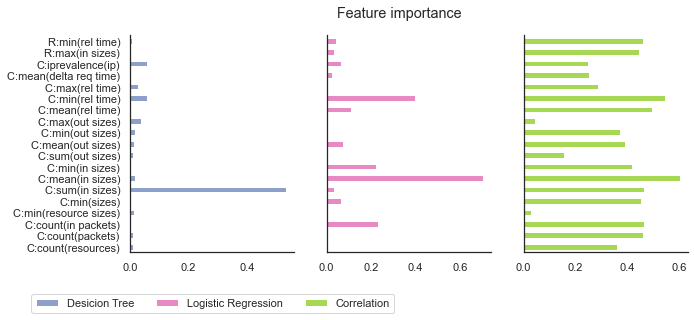

In [62]:
important_features = feature_importance_model(models, X_train)
#important_features = important_features.sort_index(ascending=False)
important_features = important_features[(important_features['dt'] > 0.01) | (important_features['lr'] > 0.01)]

fig, axs = plt.subplots(1, len(important_features.columns), sharey=True, figsize=(10,math.ceil(len(important_features)*.2)))
for ax, color, col in zip(axs, color_cycle[2:], important_features.columns):
    important_features = important_features[important_features > 0]
    
    important_features[col].plot.barh(color=color, ax=ax)
    #ax.set_title(col)

fig.suptitle("Feature importance")
fig.legend(['Desicion Tree', 'Logistic Regression', 'Correlation'], ncol=len(important_features.columns), bbox_to_anchor=(0.5,0))
fig.savefig(ASSETS / f'feature-importance-by-model{CHART_FILE_EXTENSION}')

In [54]:
from sklearn.inspection import permutation_importance

permutation_df = pd.DataFrame()


for i, model in enumerate(models):
    print(model)
    importance_mean = permutation_importance(model, X_train, y_train, n_repeats=5)['importances_mean']
    permutation_df[i] = importance_mean

DecisionTreeClassifier(max_depth=16)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, penalty='l1',
                                    solver='liblinear'))])


In [55]:
permutation_df.columns = ['Decision Tree', 'Logistic Regression']
permutation_df.index = X.columns
permutation_df

,Decision Tree,Logistic Regression
C:count(resources),0.037526,0.000000
C:count(packets),0.042621,0.000000
C:count(in packets),0.008510,0.007566
C:count(out packets),0.011634,0.000000
C:mean(resource sizes),0.012315,0.000000
...,...,...
R:std(rel time),0.008869,0.000000
R:min(rel time),0.008911,0.000395
R:max(rel time),0.005894,0.000000
R:span(rel time),0.017115,0.000000


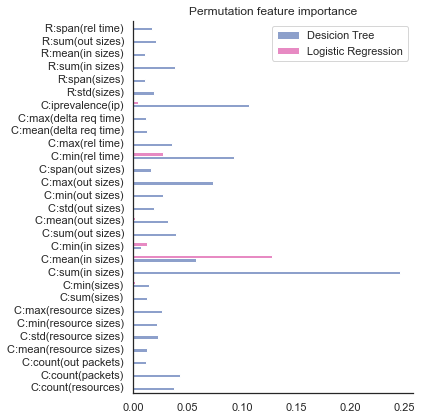

In [63]:
#permutation_df = permutation_df.sort_index(ascending=False)
permutation_df_filtered = permutation_df[(permutation_df['Decision Tree'] > 0.01) | (permutation_df['Logistic Regression'] > 0.01)]
permutation_df_filtered.plot.barh(color=color_cycle[2:], figsize=(6,math.ceil(len(permutation_df_filtered)*.2)))

# Random shuffling of the feature breaks the relationship between the featur and the target
plt.title("Permutation feature importance")
plt.legend(['Desicion Tree', 'Logistic Regression'])
plt.tight_layout()

### Feature Importance Subdataset

In [ ]:
important_features = feature_importance_model(models_com, X_train[feature_names['communication']])
important_features = important_features.sort_index(ascending=False)

fig, axs = plt.subplots(1, len(important_features.columns), sharey=True, figsize=(10,3))
for ax, color, col in zip(axs, color_cycle[2:], important_features.columns):
    important_features[col].plot.barh(color=color, ax=ax)
    #ax.set_title(col)

fig.suptitle("Communication level")
fig.legend(['Desicion Tree', 'Logistic Regression', 'Correlation'], ncol=len(important_features.columns), bbox_to_anchor=(0.5,0))
fig.tight_layout()
fig.savefig(ASSETS / f'feature-importance-communication-levl-by-model{CHART_FILE_EXTENSION}')

In [ ]:
important_features = feature_importance_model(models_res, X_train[feature_names['resource']])
important_features = important_features.sort_index(ascending=False)

fig, axs = plt.subplots(1, len(important_features.columns), sharey=True, figsize=(10,5))
for ax, color, col in zip(axs, color_cycle[2:], important_features.columns):
    important_features[col].plot.barh(color=color, ax=ax)
    #ax.set_title(col)

fig.suptitle("Resource level")
fig.legend(['Desicion Tree', 'Logistic Regression', 'Correlation'], ncol=len(important_features.columns), bbox_to_anchor=(0.5,0))
fig.tight_layout()
fig.savefig(ASSETS / f'feature-importance-resource-levl-by-model{CHART_FILE_EXTENSION}')

### Leave one feature out

In [ ]:
loo_metrics = {}
cols = {'none': []}
for col in feature_names['resource']:
    start = col.find('(')+1
    end = col.find(')')
    fam = col[start:end]
    
    if fam in cols:
        cols[fam].append(col)
    else:
        cols[fam] = [col]
        
for name, col in cols.items():
    X_train_loo = X_train[feature_names['resource']].drop(col, axis=1)
    X_test_loo = X_test[feature_names['resource']].drop(col, axis=1)
    max_depth = max(len(X_train.columns) // 2, 5)
    dt = DecisionTreeClassifier(max_depth=max_depth, class_weight='balanced').fit(X_train_loo, y_train)
    y_pred = dt.predict(X_test_loo)
    loo_metrics[name] = {'acc': accuracy_score(y_test, y_pred), 'f1': f1_score(y_test, y_pred)}

In [ ]:
loo_metrics_df = pd.DataFrame(loo_metrics).T
ax = loo_metrics_df.plot.barh(color=color_cycle[4:], figsize=(5,3))
ax.legend(['Accuracy', 'F1-Score'], loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title("Leave one feature out")
ax.set_ylabel("feature")
plt.tight_layout()
plt.savefig(ASSETS / f'feature-loo-resource{CHART_FILE_EXTENSION}')

## Robustness

### ressource completeness

Drop last perecent of packages. Threshold is defiened as threshold = max(1, int(len(packts) * (1 - percent))). So pruned packets are at most (1 - p) but at least 1 packet.

In [ ]:
def drop_last_packets(df, percent=0.1):
    if percent < 0 or percent > 1:
        raise ValueError("No valid percentage was given (between 0 and 1)")
    df = df.copy()
    cols = ['packets', 'sizes', 'ip_src', 'ip_dst', 'rel_time']
    counter = 0
    for index, row in df[cols].iterrows():
        counter += 1
        if counter % (len(df) // 3) == 0:
            print(f"{counter / len(df):.3f}")
        lens = row.apply(len)
        assert lens.eq(lens[0]).all()
        threshold = max(1, int(lens[0] * (1 - percent)))
        df.loc[index, cols] = row.apply(lambda x: x[:threshold])
    
    df['outgoing'] = df.apply(lambda row: [row["packets"][i] for i, ip in enumerate(row["ip_src"])
                                                   if ip.startswith("172.17")], axis=1)
    df['outgoing_sizes'] = df.apply(lambda row: [row["sizes"][i] for i, ip in enumerate(row["ip_src"])
                                                        if ip.startswith("172.17")], axis=1)
    return df

robustness = []
for p in np.linspace(0, 1, 11):
    print(f"Prune p={p:.2f}")
    df_pruned = drop_last_packets(df_test, p)
    X_test_pruned = make_resource_features(df_pruned)
    results_res = {name: accuracy_score(y_test, model.predict(X_test_pruned)) for model, name in zip(models_res, ['dt_res', 'lr_res'])}
    results_total = {name: accuracy_score(y_test, model.predict(X_test[feature_names['communication']].join(X_test_pruned))) for model, name in zip(models, ['dt_total', 'lr_total'])}
    results = results_total | results_res
    results['prune'] = p
    robustness.append(results)
    
robustness = pd.DataFrame(robustness)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for ax, name, cols in zip(axs, ["all features", "resource level"], [['dt_total', 'lr_total'], ['dt_res', 'lr_res']]):
    robustness.plot(x='prune', y=cols, color=color_cycle[2:], ax=ax, legend=False)
    ax.set_ylabel("Accuracy")
    ax.set_title(name)

fig.suptitle("Model quality with pruned test data")
fig.legend(['Desicion Tree', 'Logistic Regression'], ncol=2, bbox_to_anchor=(0.31,0))
fig.tight_layout()
fig.savefig(ASSETS / f'feature-pruned-data{CHART_FILE_EXTENSION}')